In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Models used
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Data cleaning

In [140]:
flights = pd.read_csv("../../sample_project/FlightDelays.csv")
flights.head(25)
flights["CARRIER"].unique()

array(['OH', 'DH', 'DL', 'MQ', 'UA', 'US', 'RU', 'CO'], dtype=object)

In [4]:
flights["DEP_DIFF"] = flights["CRS_DEP_TIME"] - flights["DEP_TIME"]
flights.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,DEP_DIFF
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime,0
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime,0
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime,0
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime,6
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime,4


In [5]:
negative_difference = flights[(flights["DEP_DIFF"] < 0) & (flights["Flight Status"] == "delayed")]
negative_difference.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,DEP_DIFF
53,1455,DH,1531,LGA,229,01/02/2004,7211,IAD,0,5,2,N665BR,delayed,-76
56,1039,DH,1236,LGA,229,01/02/2004,7792,IAD,0,5,2,N665BR,delayed,-197
62,2120,DH,2305,JFK,228,01/02/2004,7814,IAD,0,5,2,N657BR,delayed,-185
96,1245,DH,1350,EWR,213,01/02/2004,7303,IAD,0,5,2,N686BR,delayed,-105
97,1430,DH,1512,EWR,213,01/02/2004,7307,IAD,0,5,2,N309UE,delayed,-82


In [6]:
negative_difference.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 53 to 2164
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CRS_DEP_TIME   331 non-null    int64 
 1   CARRIER        331 non-null    object
 2   DEP_TIME       331 non-null    int64 
 3   DEST           331 non-null    object
 4   DISTANCE       331 non-null    int64 
 5   FL_DATE        331 non-null    object
 6   FL_NUM         331 non-null    int64 
 7   ORIGIN         331 non-null    object
 8   Weather        331 non-null    int64 
 9   DAY_WEEK       331 non-null    int64 
 10  DAY_OF_MONTH   331 non-null    int64 
 11  TAIL_NUM       331 non-null    object
 12  Flight Status  331 non-null    object
 13  DEP_DIFF       331 non-null    int64 
dtypes: int64(8), object(6)
memory usage: 38.8+ KB


In [7]:
print("minimum")
print(negative_difference["DEP_DIFF"].min())
print()
print("maximum")
print(negative_difference["DEP_DIFF"].max())

minimum
-425

maximum
-1


# One Hot encoding

In [8]:
columns_to_exclude_OH = ["CRS_DEP_TIME", "DISTANCE","DEP_DIFF", "Flight Status"]
encoded_data_OH = pd.get_dummies(negative_difference.drop(columns_to_exclude_OH, axis=1))
encoded_data_OH.head()

,DEP_TIME,FL_NUM,Weather,DAY_WEEK,DAY_OF_MONTH,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,...,TAIL_NUM_N927DA,TAIL_NUM_N928DL,TAIL_NUM_N931DL,TAIL_NUM_N940DL,TAIL_NUM_N949CA,TAIL_NUM_N954DL,TAIL_NUM_N962DL,TAIL_NUM_N970DL,TAIL_NUM_N973CA,TAIL_NUM_N997DL
53,1531,7211,0,5,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56,1236,7792,0,5,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,2305,7814,0,5,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,1350,7303,0,5,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,1512,7307,0,5,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
encoded_data_OH = pd.concat([encoded_data_OH, negative_difference["DEP_DIFF"]], axis=1)
encoded_data_OH = pd.concat([encoded_data_OH, negative_difference["DISTANCE"]], axis=1)

In [10]:
encoded_data_OH

,DEP_TIME,FL_NUM,Weather,DAY_WEEK,DAY_OF_MONTH,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,...,TAIL_NUM_N931DL,TAIL_NUM_N940DL,TAIL_NUM_N949CA,TAIL_NUM_N954DL,TAIL_NUM_N962DL,TAIL_NUM_N970DL,TAIL_NUM_N973CA,TAIL_NUM_N997DL,DEP_DIFF,DISTANCE
53,1531,7211,0,5,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,-76,229
56,1236,7792,0,5,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,-197,229
62,2305,7814,0,5,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,-185,228
96,1350,7303,0,5,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,-105,213
97,1512,7307,0,5,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,-82,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,1748,3372,0,5,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-28,169
2128,1513,2403,0,5,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-58,169
2146,1601,2261,0,5,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-76,199
2156,931,7800,0,6,31,0,1,0,0,0,...,0,0,0,0,0,0,0,0,-91,228


In [137]:
corr_matrix_OH = encoded_data_OH.corr()

In [138]:
corr_matrix_OH

,DEP_TIME,FL_NUM,Weather,DAY_WEEK,DAY_OF_MONTH,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,...,TAIL_NUM_N931DL,TAIL_NUM_N940DL,TAIL_NUM_N949CA,TAIL_NUM_N954DL,TAIL_NUM_N962DL,TAIL_NUM_N970DL,TAIL_NUM_N973CA,TAIL_NUM_N997DL,DEP_DIFF,DISTANCE
DEP_TIME,1.000000,0.106515,-0.117154,0.081190,-0.101015,0.075741,0.076933,-0.102651,0.042825,0.003239,...,-0.006501,-0.009924,-0.005816,-0.011293,0.002536,-0.017317,0.003084,-0.010608,-0.231210,0.001696
FL_NUM,0.106515,1.000000,0.014638,0.028649,0.010403,-0.382290,0.861875,-0.430618,0.074105,0.061028,...,-0.082307,-0.082307,0.030375,-0.082307,-0.082307,-0.082307,0.030375,-0.082307,-0.201671,0.535932
Weather,-0.117154,0.014638,1.000000,-0.262008,0.355666,-0.001267,-0.008705,-0.009665,0.095631,-0.036182,...,-0.018009,-0.018009,-0.018009,-0.018009,-0.018009,-0.018009,-0.018009,-0.018009,-0.047646,0.086707
DAY_WEEK,0.081190,0.028649,-0.262008,1.000000,-0.140753,-0.070236,0.015505,0.006094,0.034422,0.030362,...,0.086475,0.034574,0.008624,0.008624,0.008624,0.086475,0.086475,0.060525,-0.061354,-0.032261
DAY_OF_MONTH,-0.101015,0.010403,0.355666,-0.140753,1.000000,-0.063066,0.008484,0.124300,0.036450,-0.042864,...,0.051531,0.083212,0.032523,0.076876,-0.056183,-0.037175,-0.081528,-0.087864,0.104350,0.119824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAIL_NUM_N970DL,-0.017317,-0.082307,-0.018009,0.086475,-0.037175,-0.014328,-0.040973,0.162698,-0.027212,-0.006088,...,-0.003030,-0.003030,-0.003030,-0.003030,-0.003030,1.000000,-0.003030,-0.003030,0.065014,0.006067
TAIL_NUM_N973CA,0.003084,0.030375,-0.018009,0.086475,-0.081528,-0.014328,-0.040973,-0.018625,-0.027212,0.497722,...,-0.003030,-0.003030,-0.003030,-0.003030,-0.003030,-0.003030,1.000000,-0.003030,-0.049530,-0.092804
TAIL_NUM_N997DL,-0.010608,-0.082307,-0.018009,0.060525,-0.087864,-0.014328,-0.040973,0.162698,-0.027212,-0.006088,...,-0.003030,-0.003030,-0.003030,-0.003030,-0.003030,-0.003030,-0.003030,1.000000,0.027345,0.006067
DEP_DIFF,-0.231210,-0.201671,-0.047646,-0.061354,0.104350,0.070616,-0.217983,0.201149,0.089968,-0.082909,...,0.004283,0.023502,0.000439,0.031189,-0.046455,0.065014,-0.049530,0.027345,1.000000,-0.010058


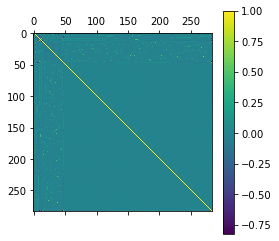

In [12]:
plt.matshow(corr_matrix_OH)
plt.colorbar()
plt.show()

In [13]:
high_correlations_OH_Base = np.abs(corr_matrix_OH["DEP_DIFF"]) > 0.00
high_correlations_OH_5  = np.abs(corr_matrix_OH["DEP_DIFF"]) > 0.05
high_correlations_OH_10 = np.abs(corr_matrix_OH["DEP_DIFF"]) > 0.10
high_correlations_OH_15 = np.abs(corr_matrix_OH["DEP_DIFF"]) > 0.15
high_correlations_OH_20 = np.abs(corr_matrix_OH["DEP_DIFF"]) > 0.20
high_correlations_OH_25 = np.abs(corr_matrix_OH["DEP_DIFF"]) > 0.25

highly_correlated_columns_OH = encoded_data_OH.columns[high_correlations_OH_25]
print("Columns with high correlation (abs. value > 0.7) with flight_delay_duration:")
print(highly_correlated_columns_OH)

Columns with high correlation (abs. value > 0.7) with flight_delay_duration:
Index(['TAIL_NUM_N14933', 'DEP_DIFF'], dtype='object')


# Linear Regression One Hot Encoding

In [18]:
#high_correlations_OH_Base
#high_correlations_OH_5
#high_correlations_OH_10
#high_correlations_OH_15
#high_correlations_OH_20
#high_correlations_OH_25
highly_correlated_columns_OH_Base = encoded_data_OH.columns[high_correlations_OH_Base]
highly_correlated_columns_OH_5 = encoded_data_OH.columns[high_correlations_OH_5]
highly_correlated_columns_OH_10 = encoded_data_OH.columns[high_correlations_OH_10]
highly_correlated_columns_OH_15 = encoded_data_OH.columns[high_correlations_OH_15]
highly_correlated_columns_OH_20 = encoded_data_OH.columns[high_correlations_OH_20]
highly_correlated_columns_OH_25 = encoded_data_OH.columns[high_correlations_OH_25]

highly_correlated_columns_OH_Base = highly_correlated_columns_OH_Base.drop("DEP_DIFF")
highly_correlated_columns_OH_5 = highly_correlated_columns_OH_5.drop("DEP_DIFF")
highly_correlated_columns_OH_10 = highly_correlated_columns_OH_10.drop("DEP_DIFF")
highly_correlated_columns_OH_15 = highly_correlated_columns_OH_15.drop("DEP_DIFF")
highly_correlated_columns_OH_20 = highly_correlated_columns_OH_20.drop("DEP_DIFF")
highly_correlated_columns_OH_25 = highly_correlated_columns_OH_25.drop("DEP_DIFF")
#Universal Variables
model = LinearRegression()

#Testing the correct columns
highly_correlated_columns_OH_25

Index(['TAIL_NUM_N14933'], dtype='object')

### BASE

In [19]:

X = encoded_data_OH[highly_correlated_columns_OH_Base]
y = encoded_data_OH["DEP_DIFF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 6325.052391056604
Root Mean Squared Error: 79.53019798200306
R-squared: -0.32418036991195986


C:\Users\aruizmartinez\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\aruizmartinez\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


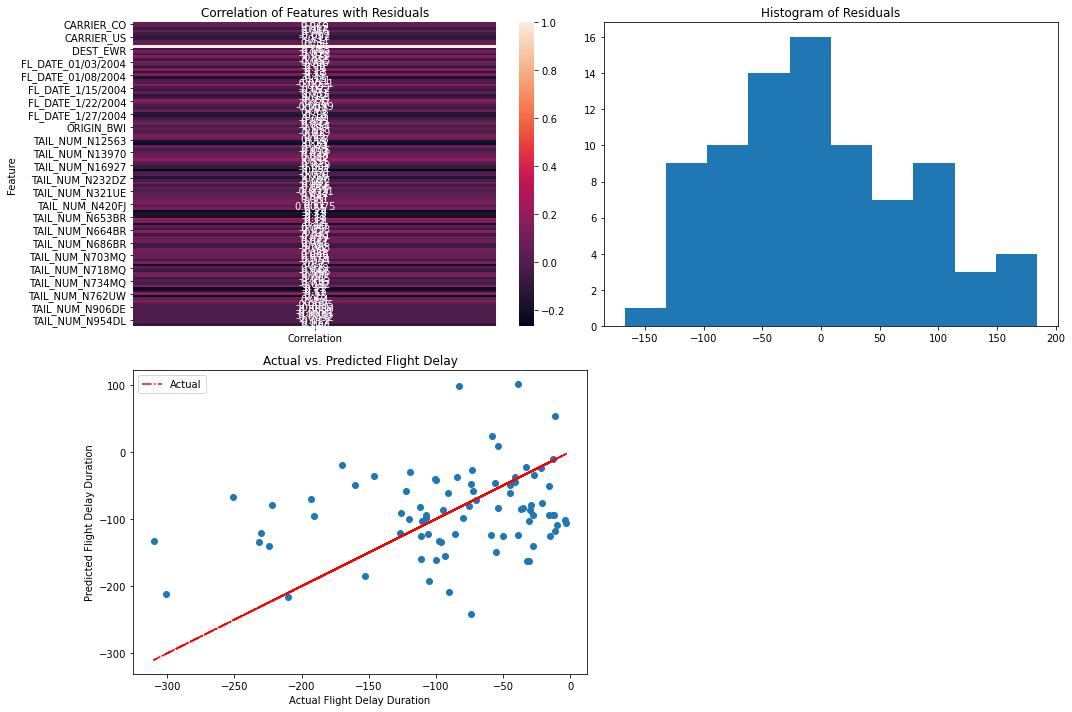

In [20]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Predictions vs. actual values scatter plot
predictions = model.predict(X_test)
ax3.scatter(y_test, predictions)
ax3.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax3.set_xlabel("Actual Flight Delay Duration")
ax3.set_ylabel("Predicted Flight Delay Duration")
ax3.set_title("Actual vs. Predicted Flight Delay")
ax3.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")



# Heatmap of feature correlations with residuals
heatmap_data = pd.DataFrame({
    "Feature": encoded_data_OH.columns,
    "Correlation": np.corrcoef(X_test.T, residuals)[:, 0]
})
sns.heatmap(heatmap_data.pivot_table(values="Correlation", index="Feature"), annot=True, ax=ax1)
ax1.set_title("Correlation of Features with Residuals")



# Hide the empty subplot
ax4.axis('off')

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()

### 5% Correlation

In [21]:
X = encoded_data_OH[highly_correlated_columns_OH_5]
y = encoded_data_OH["DEP_DIFF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 4438.033677931443
Root Mean Squared Error: 66.6185685671153
R-squared: 0.07087614236452544


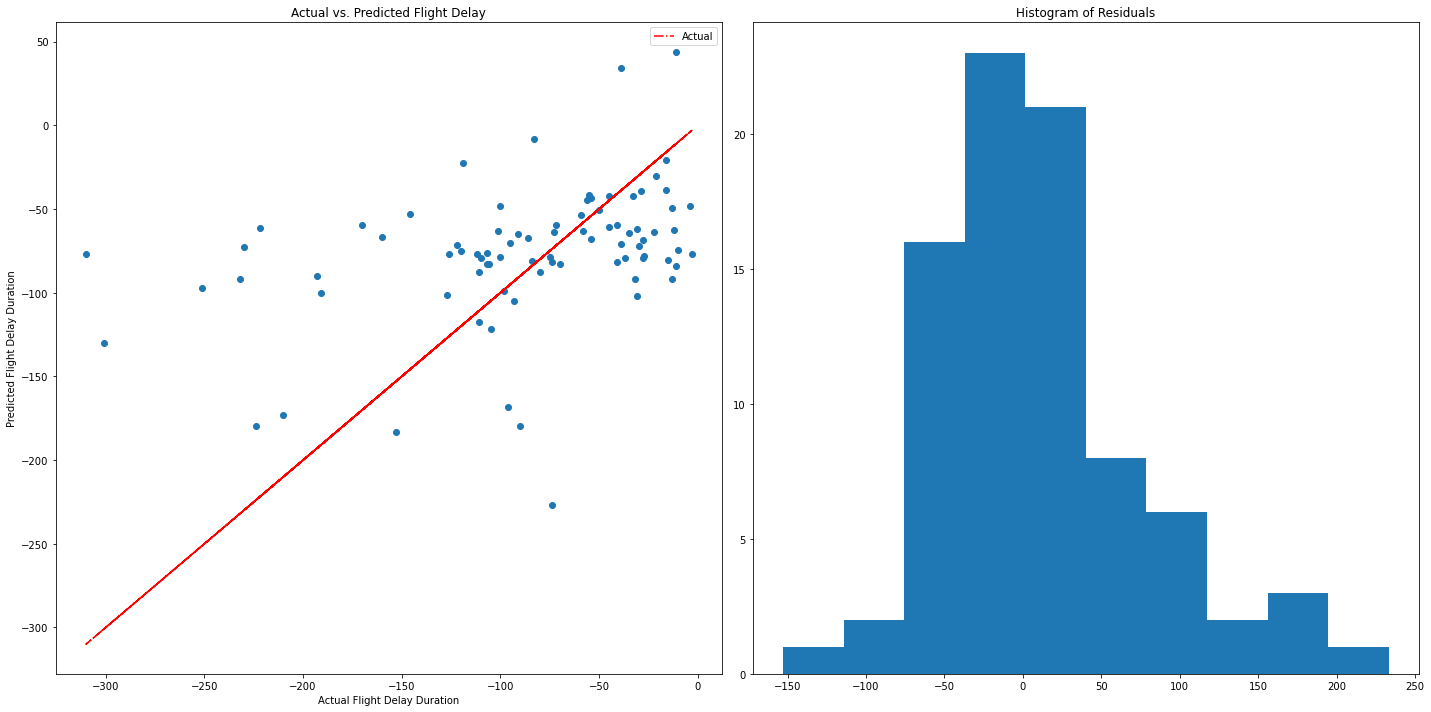

In [22]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = model.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")



# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()

### 10% Correlation

In [23]:
X = encoded_data_OH[highly_correlated_columns_OH_10]
y = encoded_data_OH["DEP_DIFF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 4033.8529831768647
Root Mean Squared Error: 63.51262066059678
R-squared: 0.15549332951196404


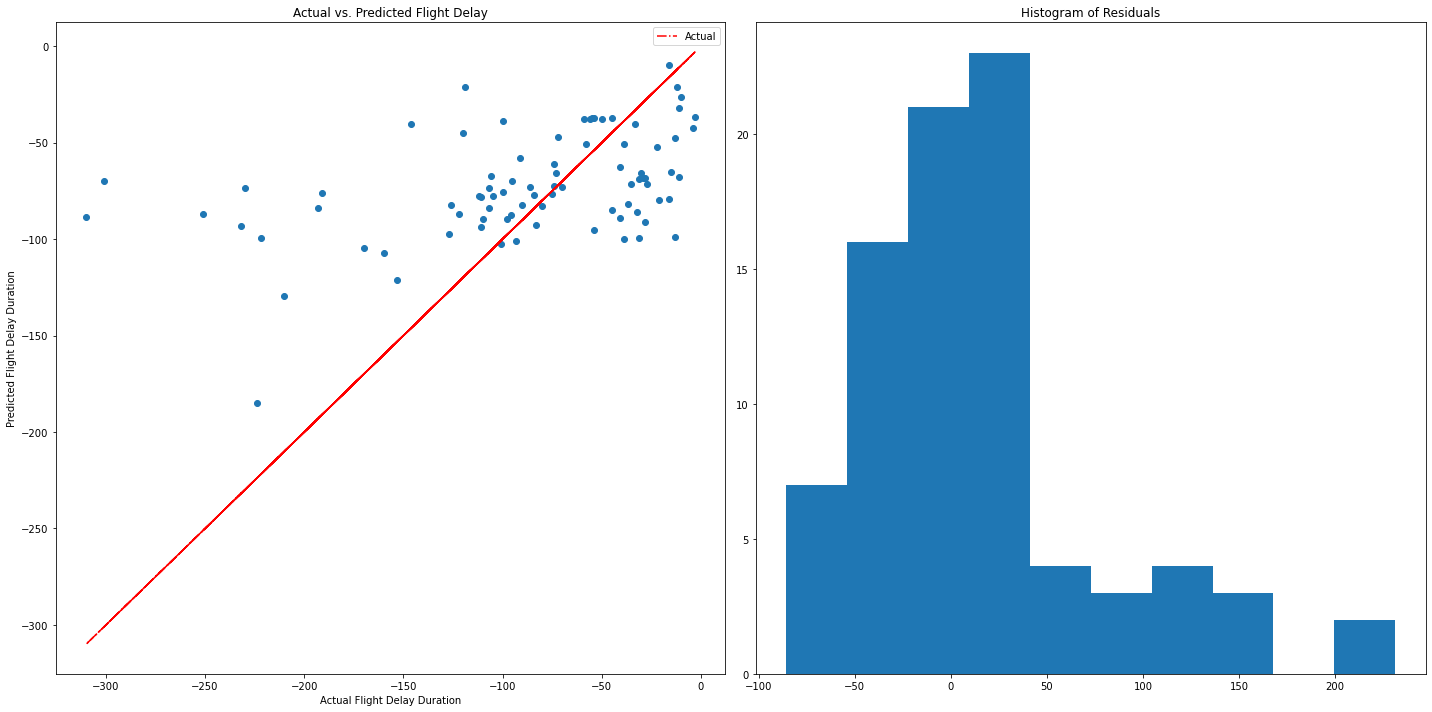

In [24]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = model.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")



# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()

### 15% Correlation

In [25]:
X = encoded_data_OH[highly_correlated_columns_OH_15]
y = encoded_data_OH["DEP_DIFF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 4094.6910838510003
Root Mean Squared Error: 63.98977327550865
R-squared: 0.1427565783082383


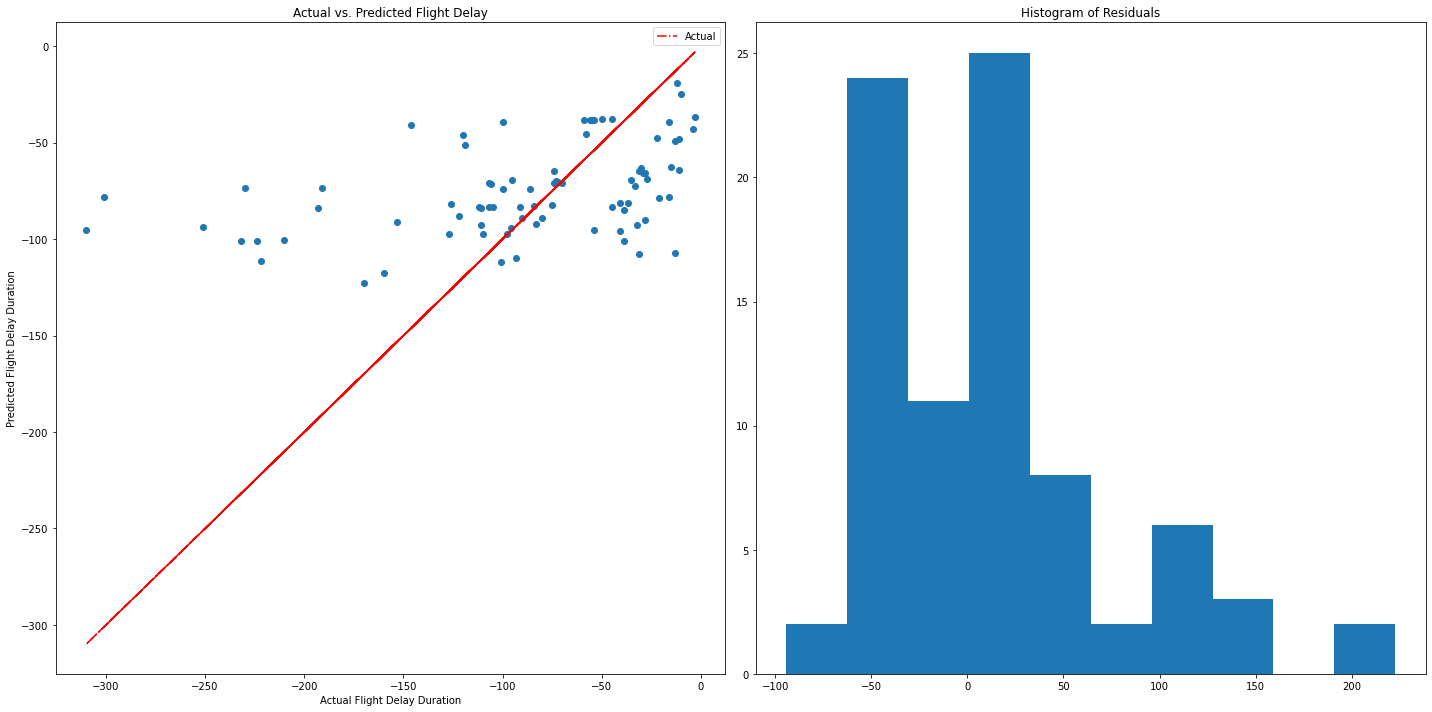

In [26]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = model.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()

### 20% Correlation

In [27]:
X = encoded_data_OH[highly_correlated_columns_OH_20]
y = encoded_data_OH["DEP_DIFF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 4039.483402534193
Root Mean Squared Error: 63.556930405221685
R-squared: 0.154314573933925


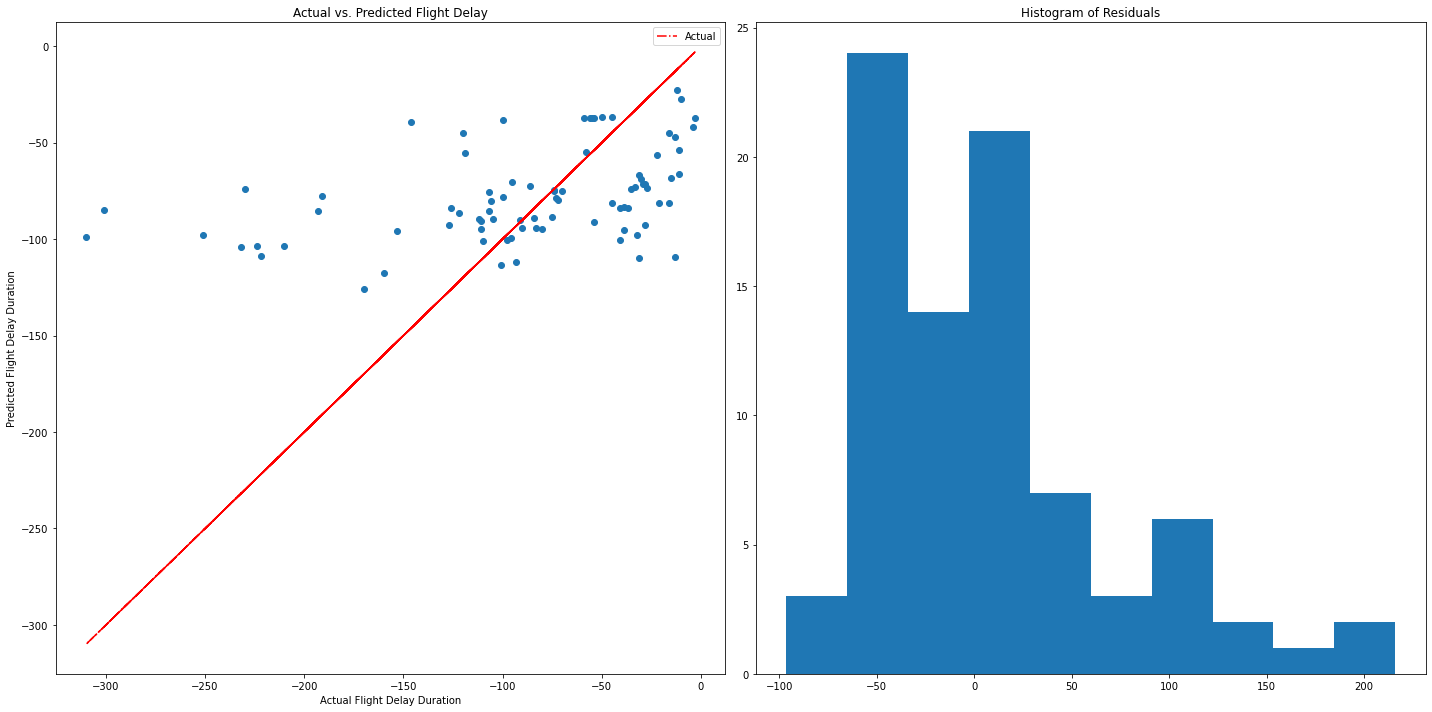

In [28]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = model.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()

### 25% Correlation

In [29]:
X = encoded_data_OH[highly_correlated_columns_OH_25]
y = encoded_data_OH["DEP_DIFF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 4791.253379167641
Root Mean Squared Error: 69.21888022185595
R-squared: -0.0030721138277061133


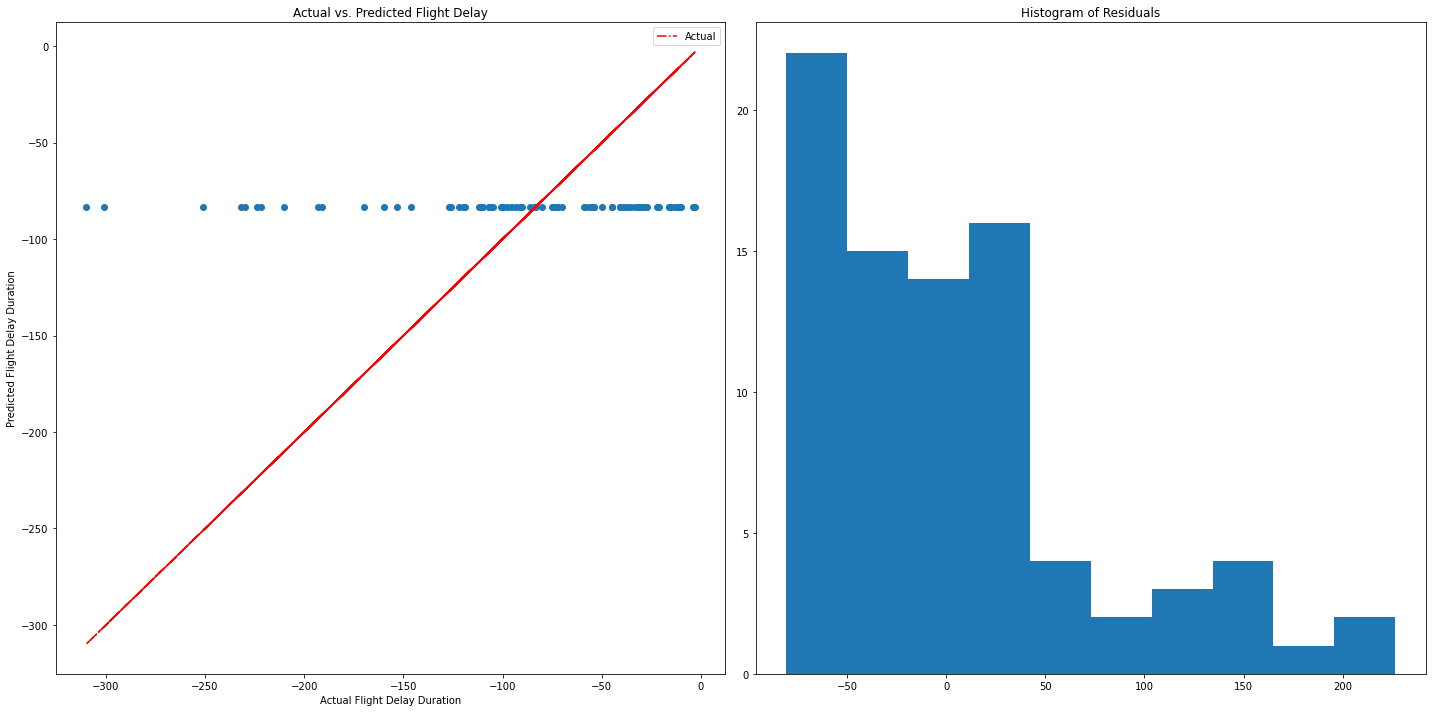

In [30]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = model.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()

# Gradient Boosting Regression

### Base

In [43]:
X = encoded_data_OH[highly_correlated_columns_OH_Base]
y = encoded_data_OH["DEP_DIFF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 3887.782191191055
Root Mean Squared Error: 62.35208249281699
R-squared: 0.17966987898771614


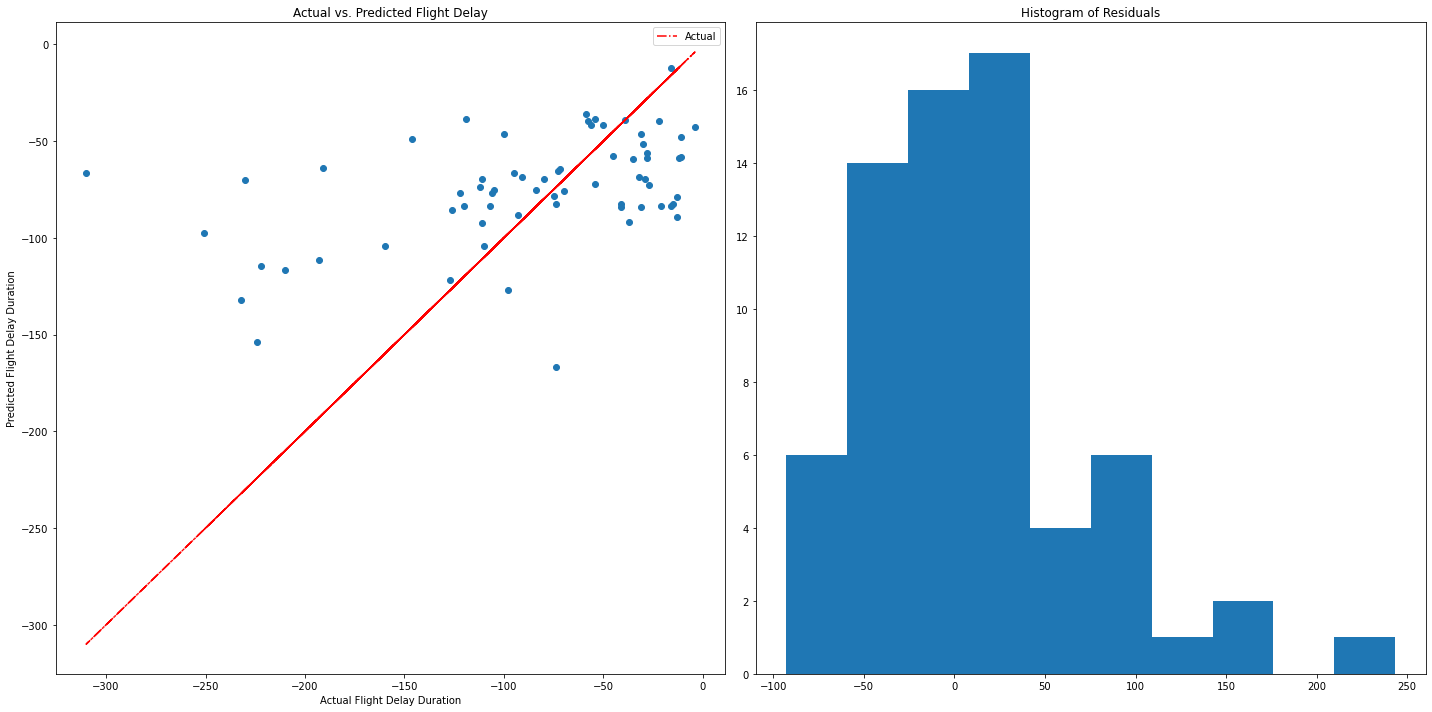

In [44]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = gbr.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()

### 5% Correlation

In [45]:
X = encoded_data_OH[highly_correlated_columns_OH_5]
y = encoded_data_OH["DEP_DIFF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 3819.4737033674833
Root Mean Squared Error: 61.80189077501985
R-squared: 0.1940831118610603


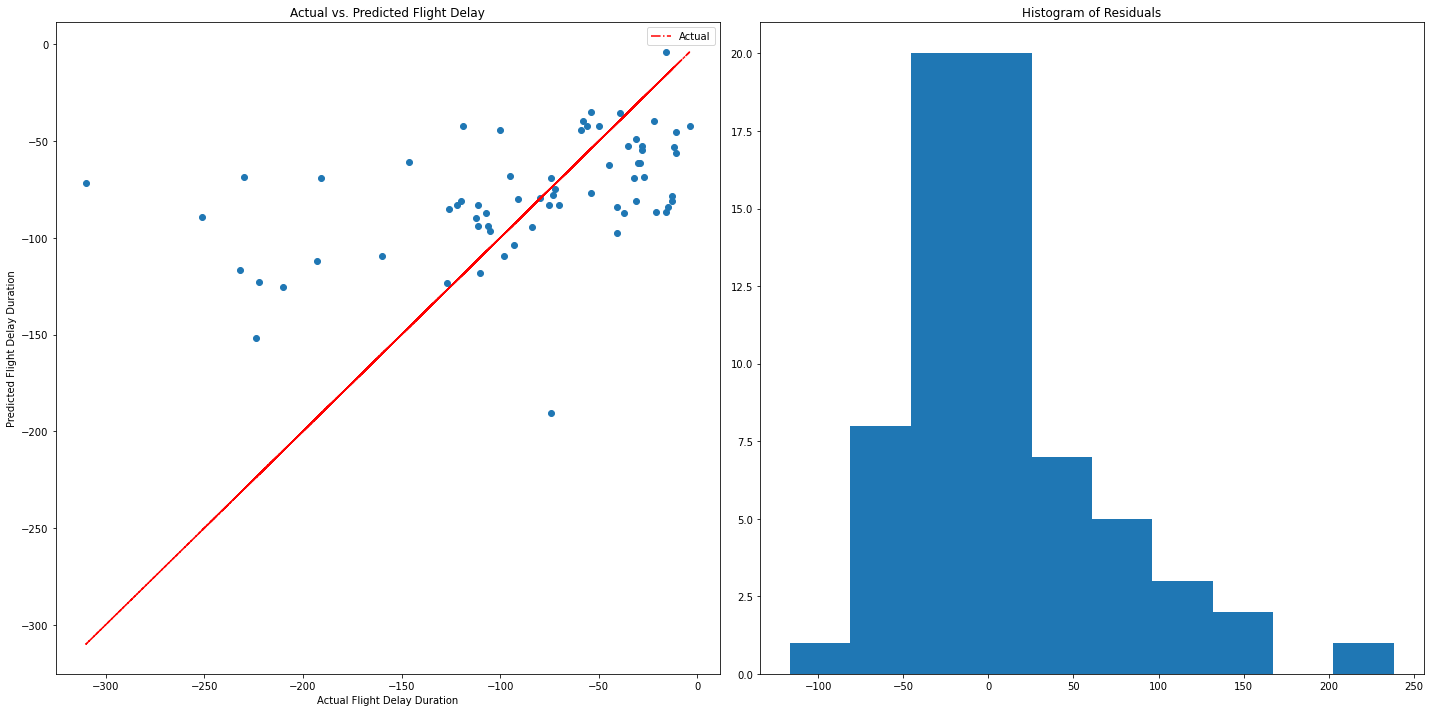

In [46]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = gbr.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()

### 10% Correlation

In [47]:
X = encoded_data_OH[highly_correlated_columns_OH_10]
y = encoded_data_OH["DEP_DIFF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 3313.8604030685597
Root Mean Squared Error: 57.56613937957417
R-squared: 0.300768568870309


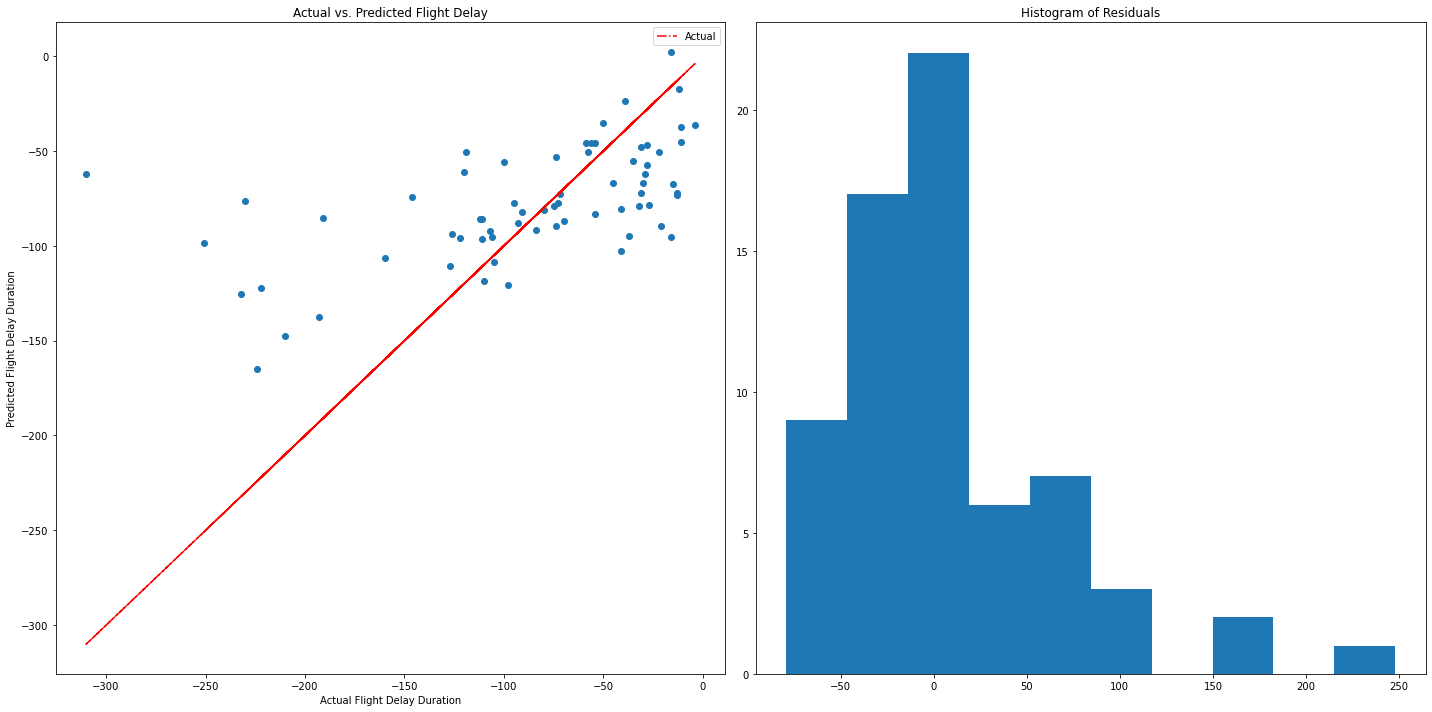

In [48]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = gbr.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()

### 15% Correlation

In [49]:
X = encoded_data_OH[highly_correlated_columns_OH_15]
y = encoded_data_OH["DEP_DIFF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 3168.6585609428507
Root Mean Squared Error: 56.290839049909806
R-squared: 0.33140645928301704


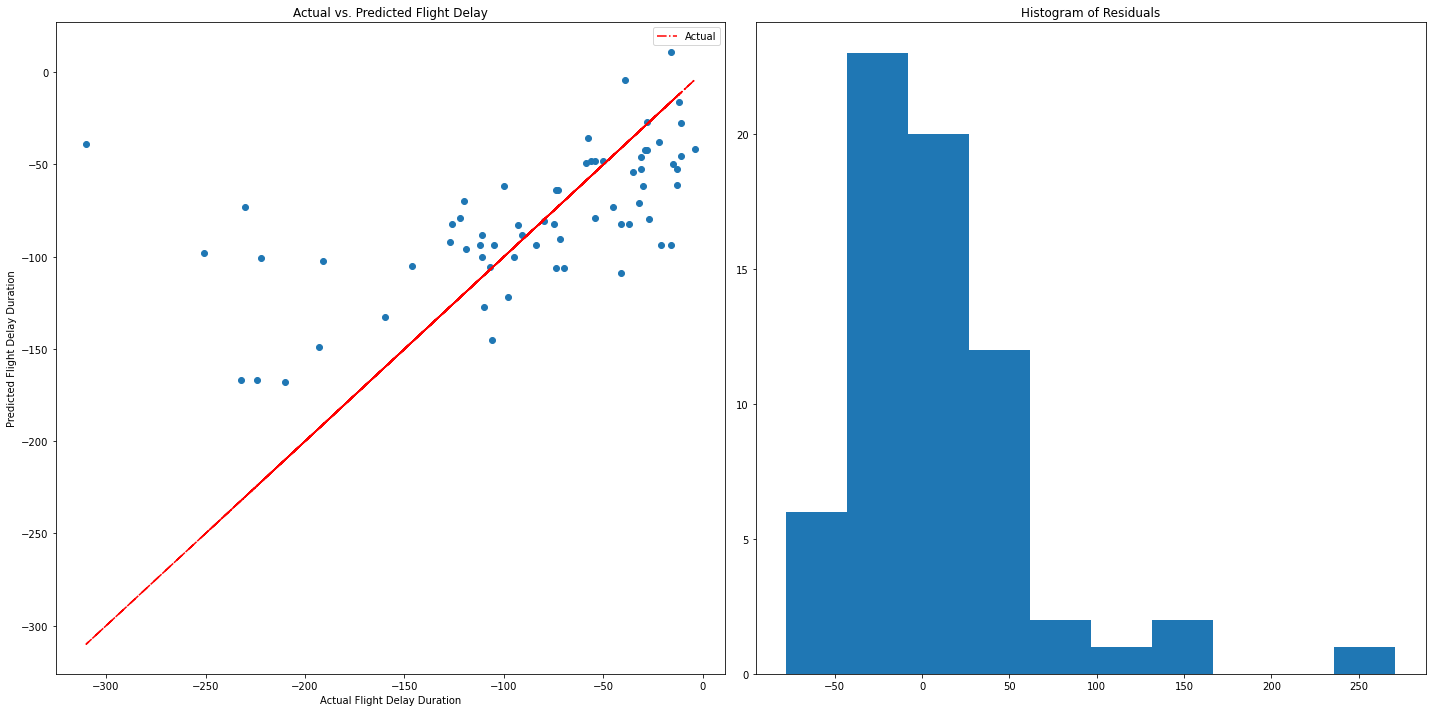

In [50]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = gbr.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()

### 20% Correlation

In [51]:
X = encoded_data_OH[highly_correlated_columns_OH_20]
y = encoded_data_OH["DEP_DIFF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 3172.5004067531236
Root Mean Squared Error: 56.32495367732781
R-squared: 0.3305958218338326


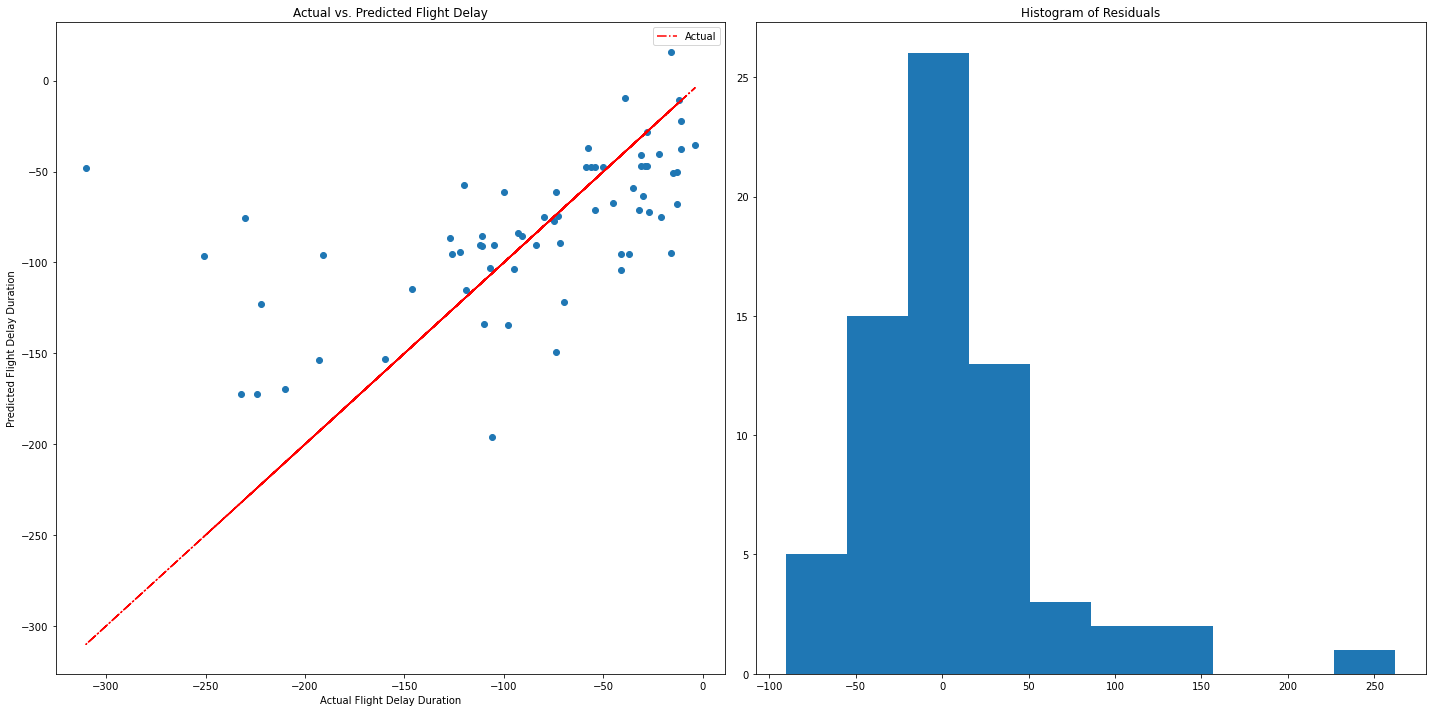

In [52]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = gbr.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()

### 25% Correlation

In [53]:
X = encoded_data_OH[highly_correlated_columns_OH_25]
y = encoded_data_OH["DEP_DIFF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 4744.227742554256
Root Mean Squared Error: 68.87835467368727
R-squared: -0.0010419120128410952


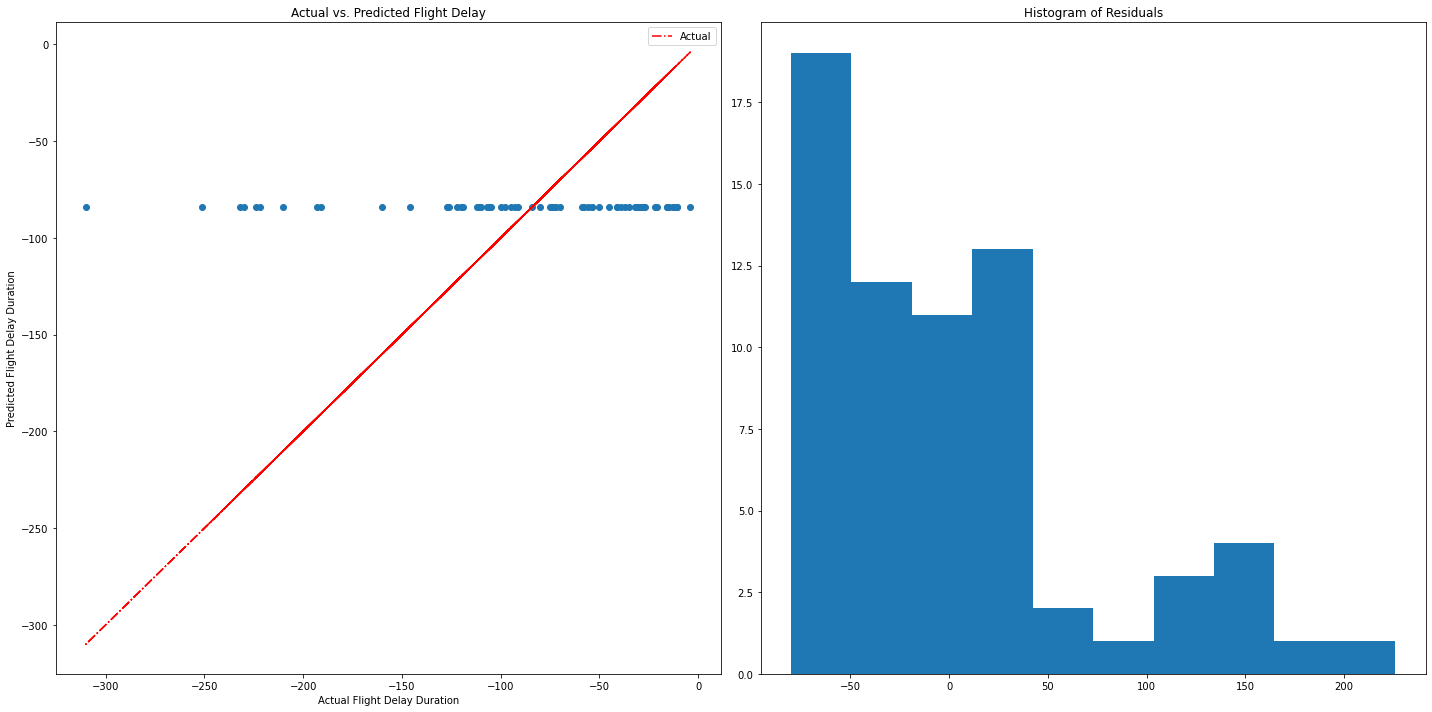

In [54]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = gbr.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()

# Cat Boost

### BASE

In [118]:
# Separate features (X) and target variable (y)
X = encoded_data_OH[highly_correlated_columns_OH_Base]
y = encoded_data_OH["DEP_DIFF"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CatBoost Regressor model
catboost = CatBoostRegressor(random_state=42)  # Adjust hyperparameters as needed

# Train the model
catboost.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Feature importances
feature_importances = catboost.get_feature_importance(prettified=True)
print("Feature Importances:\n", feature_importances)

Learning rate set to 0.033174
0:	learn: 71.8863960	total: 1.45ms	remaining: 1.45s
1:	learn: 71.6571894	total: 2.77ms	remaining: 1.38s
2:	learn: 71.4215277	total: 4.26ms	remaining: 1.42s
3:	learn: 71.2189380	total: 5.81ms	remaining: 1.45s
4:	learn: 71.1406930	total: 7.16ms	remaining: 1.42s
5:	learn: 70.8903768	total: 8.44ms	remaining: 1.4s
6:	learn: 70.5717795	total: 9.74ms	remaining: 1.38s
7:	learn: 70.3393727	total: 11.1ms	remaining: 1.37s
8:	learn: 70.0925985	total: 12.2ms	remaining: 1.35s
9:	learn: 69.7964260	total: 13.8ms	remaining: 1.36s
10:	learn: 69.5989918	total: 15ms	remaining: 1.34s
11:	learn: 69.3287785	total: 16.2ms	remaining: 1.33s
12:	learn: 69.2555715	total: 17.4ms	remaining: 1.32s
13:	learn: 69.1730556	total: 18.7ms	remaining: 1.32s
14:	learn: 68.9491885	total: 20ms	remaining: 1.32s
15:	learn: 68.7892298	total: 21.2ms	remaining: 1.31s
16:	learn: 68.6283883	total: 22.4ms	remaining: 1.3s
17:	learn: 68.4568261	total: 23.7ms	remaining: 1.29s
18:	learn: 68.1181710	total: 24.

210:	learn: 46.4344714	total: 291ms	remaining: 1.09s
211:	learn: 46.3773939	total: 292ms	remaining: 1.08s
212:	learn: 46.3273693	total: 293ms	remaining: 1.08s
213:	learn: 46.2292629	total: 295ms	remaining: 1.08s
214:	learn: 46.1401935	total: 296ms	remaining: 1.08s
215:	learn: 46.0919167	total: 298ms	remaining: 1.08s
216:	learn: 46.0359453	total: 299ms	remaining: 1.08s
217:	learn: 45.9874851	total: 301ms	remaining: 1.08s
218:	learn: 45.8997700	total: 302ms	remaining: 1.08s
219:	learn: 45.8501733	total: 303ms	remaining: 1.07s
220:	learn: 45.8017661	total: 305ms	remaining: 1.07s
221:	learn: 45.6481170	total: 306ms	remaining: 1.07s
222:	learn: 45.5941853	total: 307ms	remaining: 1.07s
223:	learn: 45.4679802	total: 309ms	remaining: 1.07s
224:	learn: 45.4146281	total: 310ms	remaining: 1.07s
225:	learn: 45.2256513	total: 311ms	remaining: 1.07s
226:	learn: 45.0556464	total: 313ms	remaining: 1.06s
227:	learn: 45.0002585	total: 314ms	remaining: 1.06s
228:	learn: 44.8640368	total: 315ms	remaining:

430:	learn: 33.5684445	total: 585ms	remaining: 772ms
431:	learn: 33.5506221	total: 586ms	remaining: 771ms
432:	learn: 33.5322640	total: 588ms	remaining: 770ms
433:	learn: 33.5138112	total: 589ms	remaining: 768ms
434:	learn: 33.4961411	total: 590ms	remaining: 767ms
435:	learn: 33.4728727	total: 592ms	remaining: 766ms
436:	learn: 33.3693992	total: 594ms	remaining: 765ms
437:	learn: 33.3512178	total: 595ms	remaining: 764ms
438:	learn: 33.3331786	total: 597ms	remaining: 762ms
439:	learn: 33.2898680	total: 598ms	remaining: 761ms
440:	learn: 33.2657558	total: 599ms	remaining: 760ms
441:	learn: 33.2311417	total: 601ms	remaining: 759ms
442:	learn: 33.2012014	total: 602ms	remaining: 757ms
443:	learn: 33.1841487	total: 604ms	remaining: 756ms
444:	learn: 33.1664314	total: 605ms	remaining: 755ms
445:	learn: 33.1488128	total: 607ms	remaining: 753ms
446:	learn: 33.1199074	total: 608ms	remaining: 752ms
447:	learn: 33.0968830	total: 609ms	remaining: 750ms
448:	learn: 32.9994598	total: 610ms	remaining:

644:	learn: 26.0848567	total: 878ms	remaining: 483ms
645:	learn: 26.0721920	total: 879ms	remaining: 482ms
646:	learn: 26.0209689	total: 881ms	remaining: 480ms
647:	learn: 26.0098798	total: 882ms	remaining: 479ms
648:	learn: 25.9979026	total: 884ms	remaining: 478ms
649:	learn: 25.9874700	total: 885ms	remaining: 477ms
650:	learn: 25.9760673	total: 887ms	remaining: 475ms
651:	learn: 25.9654355	total: 888ms	remaining: 474ms
652:	learn: 25.9552683	total: 890ms	remaining: 473ms
653:	learn: 25.9429753	total: 892ms	remaining: 472ms
654:	learn: 25.9273341	total: 894ms	remaining: 471ms
655:	learn: 25.9161285	total: 895ms	remaining: 469ms
656:	learn: 25.8323343	total: 897ms	remaining: 468ms
657:	learn: 25.8211507	total: 898ms	remaining: 467ms
658:	learn: 25.7405680	total: 899ms	remaining: 465ms
659:	learn: 25.7280403	total: 901ms	remaining: 464ms
660:	learn: 25.7164239	total: 902ms	remaining: 463ms
661:	learn: 25.7042988	total: 904ms	remaining: 462ms
662:	learn: 25.6922824	total: 906ms	remaining:

836:	learn: 21.9422130	total: 1.16s	remaining: 227ms
837:	learn: 21.9328956	total: 1.17s	remaining: 225ms
838:	learn: 21.8304581	total: 1.17s	remaining: 224ms
839:	learn: 21.7820390	total: 1.17s	remaining: 223ms
840:	learn: 21.7732219	total: 1.17s	remaining: 221ms
841:	learn: 21.7638740	total: 1.17s	remaining: 220ms
842:	learn: 21.7261667	total: 1.17s	remaining: 219ms
843:	learn: 21.6224651	total: 1.17s	remaining: 217ms
844:	learn: 21.6140360	total: 1.18s	remaining: 216ms
845:	learn: 21.6021663	total: 1.18s	remaining: 214ms
846:	learn: 21.5902643	total: 1.18s	remaining: 213ms
847:	learn: 21.5815373	total: 1.18s	remaining: 212ms
848:	learn: 21.5725591	total: 1.19s	remaining: 211ms
849:	learn: 21.5641529	total: 1.19s	remaining: 210ms
850:	learn: 21.5560441	total: 1.19s	remaining: 208ms
851:	learn: 21.4991280	total: 1.19s	remaining: 207ms
852:	learn: 21.4905119	total: 1.19s	remaining: 206ms
853:	learn: 21.4821601	total: 1.2s	remaining: 204ms
854:	learn: 21.4373732	total: 1.2s	remaining: 2

In [119]:
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 3582.374157380875
Root Mean Squared Error: 59.852937750630716
R-squared: 0.24411160874852744


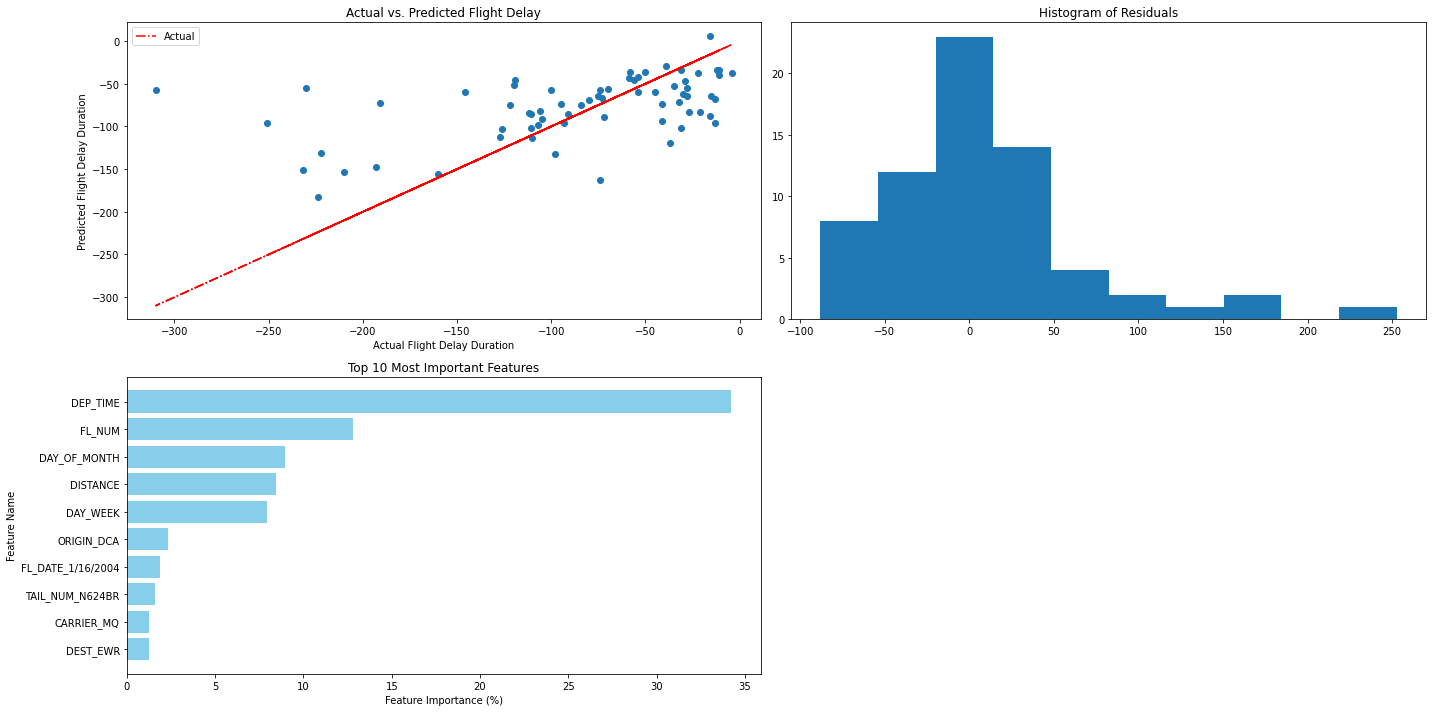

In [120]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = catboost.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Get feature importances (prettified format recommended)
feature_importances = catboost.get_feature_importance(prettified=True)

# Get top 10 features
top_10_features = feature_importances[:10]

# Extract feature names and importance values
feature_names = top_10_features["Feature Id"]
feature_importance = top_10_features["Importances"]

ax3.barh(feature_names, feature_importance, color='skyblue')
ax3.set_xlabel('Feature Importance (%)')
ax3.set_ylabel('Feature Name')
ax3.set_title('Top 10 Most Important Features')
ax3.invert_yaxis()


# Adjust layout
ax4.axis('off')
plt.tight_layout()

# Show the combined figure
plt.show()

###  5% Correlation

In [122]:
# Separate features (X) and target variable (y)
X = encoded_data_OH[highly_correlated_columns_OH_5]
y = encoded_data_OH["DEP_DIFF"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CatBoost Regressor model
catboost = CatBoostRegressor(random_state=42)  # Adjust hyperparameters as needed

# Train the model
catboost.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Feature importances
feature_importances = catboost.get_feature_importance(prettified=True)
print("Feature Importances:\n", feature_importances)

Learning rate set to 0.033174
0:	learn: 71.8544204	total: 1.32ms	remaining: 1.31s
1:	learn: 71.4816875	total: 2.48ms	remaining: 1.24s
2:	learn: 71.3707952	total: 3.45ms	remaining: 1.15s
3:	learn: 71.0328170	total: 4.37ms	remaining: 1.09s
4:	learn: 70.8571136	total: 5.33ms	remaining: 1.06s
5:	learn: 70.6360890	total: 6.25ms	remaining: 1.03s
6:	learn: 70.3018347	total: 7.27ms	remaining: 1.03s
7:	learn: 69.8317315	total: 8.45ms	remaining: 1.05s
8:	learn: 69.4856396	total: 9.66ms	remaining: 1.06s
9:	learn: 69.2218886	total: 10.7ms	remaining: 1.06s
10:	learn: 68.9965278	total: 11.9ms	remaining: 1.07s
11:	learn: 68.8894728	total: 13.2ms	remaining: 1.09s
12:	learn: 68.6596664	total: 14.4ms	remaining: 1.1s
13:	learn: 68.3563453	total: 15.7ms	remaining: 1.1s
14:	learn: 68.1698049	total: 16.8ms	remaining: 1.1s
15:	learn: 67.9394489	total: 18.1ms	remaining: 1.11s
16:	learn: 67.8263912	total: 19.1ms	remaining: 1.1s
17:	learn: 67.6689703	total: 20.3ms	remaining: 1.11s
18:	learn: 67.5809543	total: 2

291:	learn: 41.6255910	total: 286ms	remaining: 694ms
292:	learn: 41.5839157	total: 287ms	remaining: 693ms
293:	learn: 41.5513808	total: 288ms	remaining: 692ms
294:	learn: 41.4350575	total: 289ms	remaining: 691ms
295:	learn: 41.4030617	total: 290ms	remaining: 690ms
296:	learn: 41.2935983	total: 291ms	remaining: 689ms
297:	learn: 41.2529096	total: 292ms	remaining: 688ms
298:	learn: 41.2142724	total: 293ms	remaining: 687ms
299:	learn: 41.1828766	total: 294ms	remaining: 686ms
300:	learn: 41.1519858	total: 295ms	remaining: 685ms
301:	learn: 41.1214683	total: 296ms	remaining: 684ms
302:	learn: 40.9654427	total: 297ms	remaining: 683ms
303:	learn: 40.9352566	total: 298ms	remaining: 682ms
304:	learn: 40.9053655	total: 299ms	remaining: 681ms
305:	learn: 40.8704719	total: 300ms	remaining: 680ms
306:	learn: 40.8357813	total: 301ms	remaining: 679ms
307:	learn: 40.7695704	total: 302ms	remaining: 678ms
308:	learn: 40.5971071	total: 303ms	remaining: 677ms
309:	learn: 40.4623011	total: 304ms	remaining:

592:	learn: 27.8939976	total: 580ms	remaining: 398ms
593:	learn: 27.8823190	total: 581ms	remaining: 397ms
594:	learn: 27.8646868	total: 582ms	remaining: 396ms
595:	learn: 27.8087737	total: 583ms	remaining: 395ms
596:	learn: 27.7977381	total: 584ms	remaining: 395ms
597:	learn: 27.7862972	total: 586ms	remaining: 394ms
598:	learn: 27.7747781	total: 587ms	remaining: 393ms
599:	learn: 27.7081959	total: 588ms	remaining: 392ms
600:	learn: 27.6952116	total: 589ms	remaining: 391ms
601:	learn: 27.6840439	total: 590ms	remaining: 390ms
602:	learn: 27.6734795	total: 591ms	remaining: 389ms
603:	learn: 27.6074766	total: 592ms	remaining: 388ms
604:	learn: 27.5286059	total: 593ms	remaining: 387ms
605:	learn: 27.5174094	total: 594ms	remaining: 386ms
606:	learn: 27.5064604	total: 595ms	remaining: 385ms
607:	learn: 27.4954762	total: 596ms	remaining: 384ms
608:	learn: 27.4832575	total: 597ms	remaining: 383ms
609:	learn: 27.4730508	total: 598ms	remaining: 383ms
610:	learn: 27.4220550	total: 599ms	remaining:

879:	learn: 20.5489747	total: 872ms	remaining: 119ms
880:	learn: 20.5429429	total: 873ms	remaining: 118ms
881:	learn: 20.5342140	total: 874ms	remaining: 117ms
882:	learn: 20.5282143	total: 875ms	remaining: 116ms
883:	learn: 20.5215478	total: 876ms	remaining: 115ms
884:	learn: 20.5083165	total: 877ms	remaining: 114ms
885:	learn: 20.4528863	total: 878ms	remaining: 113ms
886:	learn: 20.4469588	total: 879ms	remaining: 112ms
887:	learn: 20.4408983	total: 880ms	remaining: 111ms
888:	learn: 20.3975346	total: 882ms	remaining: 110ms
889:	learn: 20.3924599	total: 882ms	remaining: 109ms
890:	learn: 20.3866049	total: 884ms	remaining: 108ms
891:	learn: 20.3802044	total: 885ms	remaining: 107ms
892:	learn: 20.3743262	total: 886ms	remaining: 106ms
893:	learn: 20.3467597	total: 887ms	remaining: 105ms
894:	learn: 20.3161617	total: 888ms	remaining: 104ms
895:	learn: 20.2892869	total: 889ms	remaining: 103ms
896:	learn: 20.2831747	total: 890ms	remaining: 102ms
897:	learn: 20.2771798	total: 891ms	remaining:

In [123]:
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 3419.6373354124353
Root Mean Squared Error: 58.477665269848416
R-squared: 0.27844941634510634


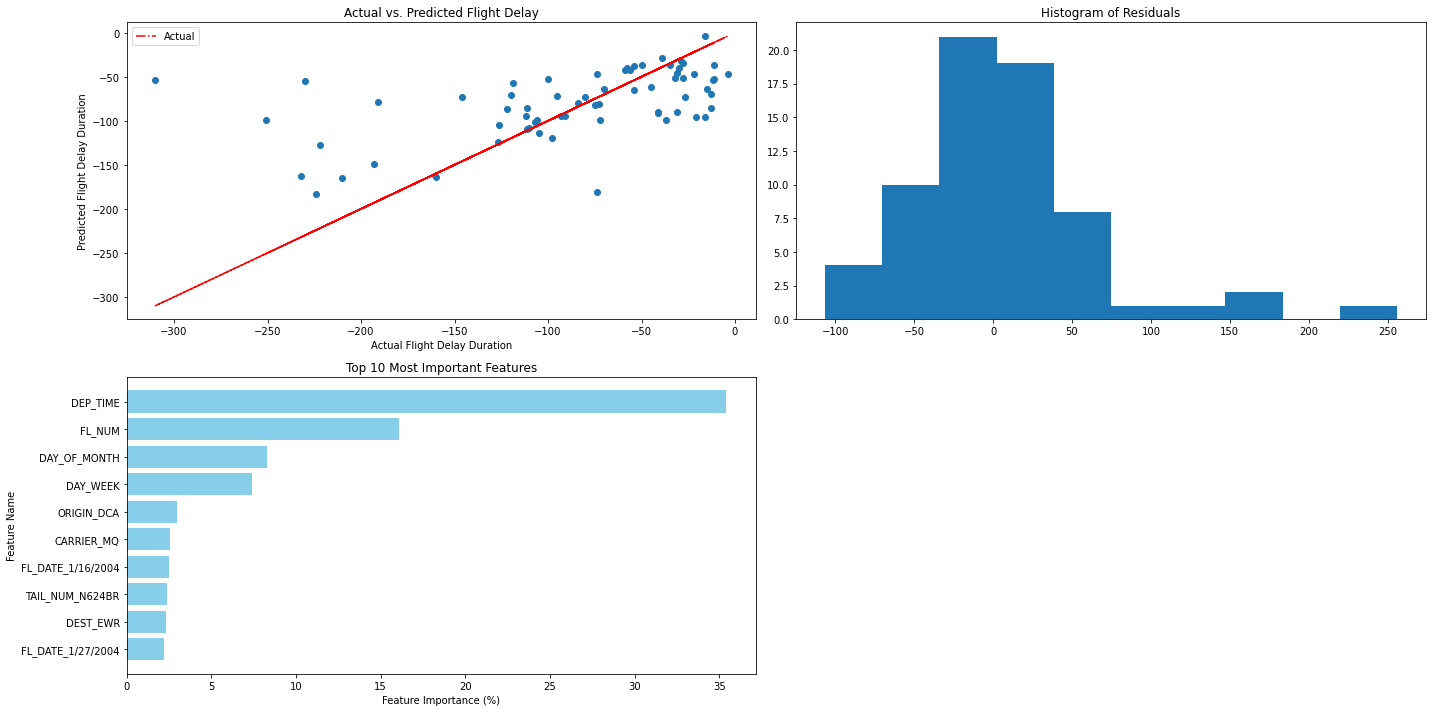

In [124]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = catboost.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Get feature importances (prettified format recommended)
feature_importances = catboost.get_feature_importance(prettified=True)

# Get top 10 features
top_10_features = feature_importances[:10]

# Extract feature names and importance values
feature_names = top_10_features["Feature Id"]
feature_importance = top_10_features["Importances"]

ax3.barh(feature_names, feature_importance, color='skyblue')
ax3.set_xlabel('Feature Importance (%)')
ax3.set_ylabel('Feature Name')
ax3.set_title('Top 10 Most Important Features')
ax3.invert_yaxis()


# Adjust layout
ax4.axis('off')
plt.tight_layout()

# Show the combined figure
plt.show()

###  10% Correlation

In [125]:
# Separate features (X) and target variable (y)
X = encoded_data_OH[highly_correlated_columns_OH_10]
y = encoded_data_OH["DEP_DIFF"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CatBoost Regressor model
catboost = CatBoostRegressor(random_state=42)  # Adjust hyperparameters as needed

# Train the model
catboost.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Feature importances
feature_importances = catboost.get_feature_importance(prettified=True)
print("Feature Importances:\n", feature_importances)

Learning rate set to 0.033174
0:	learn: 71.9810831	total: 917us	remaining: 916ms
1:	learn: 71.5305730	total: 1.62ms	remaining: 809ms
2:	learn: 71.2955784	total: 2.27ms	remaining: 754ms
3:	learn: 70.9215198	total: 2.91ms	remaining: 725ms
4:	learn: 70.7932516	total: 3.35ms	remaining: 667ms
5:	learn: 70.5812422	total: 3.98ms	remaining: 659ms
6:	learn: 70.4309178	total: 4.63ms	remaining: 656ms
7:	learn: 70.1990591	total: 5.25ms	remaining: 652ms
8:	learn: 69.8789383	total: 5.89ms	remaining: 649ms
9:	learn: 69.7530207	total: 6.53ms	remaining: 647ms
10:	learn: 69.7080528	total: 6.73ms	remaining: 605ms
11:	learn: 69.3896155	total: 7.38ms	remaining: 608ms
12:	learn: 69.2571065	total: 8.04ms	remaining: 610ms
13:	learn: 69.0180561	total: 8.74ms	remaining: 615ms
14:	learn: 68.8979514	total: 9.2ms	remaining: 604ms
15:	learn: 68.6966937	total: 9.84ms	remaining: 605ms
16:	learn: 68.5274857	total: 10.5ms	remaining: 605ms
17:	learn: 68.3414290	total: 11.1ms	remaining: 604ms
18:	learn: 68.2028776	total:

206:	learn: 49.2469960	total: 127ms	remaining: 488ms
207:	learn: 49.2231227	total: 128ms	remaining: 487ms
208:	learn: 49.0472821	total: 129ms	remaining: 487ms
209:	learn: 48.8808464	total: 129ms	remaining: 487ms
210:	learn: 48.8480031	total: 130ms	remaining: 487ms
211:	learn: 48.8081904	total: 131ms	remaining: 487ms
212:	learn: 48.7782106	total: 132ms	remaining: 487ms
213:	learn: 48.7473069	total: 133ms	remaining: 487ms
214:	learn: 48.6048413	total: 133ms	remaining: 487ms
215:	learn: 48.5626502	total: 134ms	remaining: 486ms
216:	learn: 48.3744272	total: 135ms	remaining: 486ms
217:	learn: 48.3401933	total: 135ms	remaining: 486ms
218:	learn: 48.3124960	total: 136ms	remaining: 486ms
219:	learn: 48.2793001	total: 137ms	remaining: 485ms
220:	learn: 48.2474863	total: 138ms	remaining: 485ms
221:	learn: 48.0339764	total: 138ms	remaining: 484ms
222:	learn: 48.0070026	total: 139ms	remaining: 484ms
223:	learn: 47.9760709	total: 140ms	remaining: 483ms
224:	learn: 47.9421582	total: 140ms	remaining:

405:	learn: 35.9623726	total: 261ms	remaining: 381ms
406:	learn: 35.9191753	total: 261ms	remaining: 381ms
407:	learn: 35.9110466	total: 262ms	remaining: 380ms
408:	learn: 35.9002997	total: 263ms	remaining: 380ms
409:	learn: 35.8923834	total: 263ms	remaining: 379ms
410:	learn: 35.8134315	total: 264ms	remaining: 378ms
411:	learn: 35.7998918	total: 265ms	remaining: 378ms
412:	learn: 35.7896053	total: 265ms	remaining: 377ms
413:	learn: 35.7157874	total: 266ms	remaining: 377ms
414:	learn: 35.7064854	total: 267ms	remaining: 376ms
415:	learn: 35.6218627	total: 268ms	remaining: 376ms
416:	learn: 35.6127405	total: 268ms	remaining: 375ms
417:	learn: 35.6052520	total: 269ms	remaining: 375ms
418:	learn: 35.4544977	total: 270ms	remaining: 374ms
419:	learn: 35.4456333	total: 270ms	remaining: 373ms
420:	learn: 35.3827064	total: 271ms	remaining: 373ms
421:	learn: 35.2476342	total: 272ms	remaining: 372ms
422:	learn: 35.1542963	total: 272ms	remaining: 372ms
423:	learn: 35.1460002	total: 273ms	remaining:

608:	learn: 26.9196406	total: 395ms	remaining: 254ms
609:	learn: 26.8970634	total: 396ms	remaining: 253ms
610:	learn: 26.8660189	total: 396ms	remaining: 252ms
611:	learn: 26.8411399	total: 397ms	remaining: 252ms
612:	learn: 26.7636843	total: 398ms	remaining: 251ms
613:	learn: 26.6984118	total: 398ms	remaining: 250ms
614:	learn: 26.6953716	total: 399ms	remaining: 250ms
615:	learn: 26.6328203	total: 400ms	remaining: 249ms
616:	learn: 26.5897116	total: 400ms	remaining: 248ms
617:	learn: 26.5593648	total: 401ms	remaining: 248ms
618:	learn: 26.4999721	total: 402ms	remaining: 247ms
619:	learn: 26.4337729	total: 402ms	remaining: 247ms
620:	learn: 26.4085621	total: 403ms	remaining: 246ms
621:	learn: 26.3789299	total: 404ms	remaining: 245ms
622:	learn: 26.3040667	total: 404ms	remaining: 245ms
623:	learn: 26.2543556	total: 405ms	remaining: 244ms
624:	learn: 26.2301310	total: 406ms	remaining: 243ms
625:	learn: 26.2266275	total: 406ms	remaining: 243ms
626:	learn: 26.2232030	total: 407ms	remaining:

809:	learn: 20.6455198	total: 530ms	remaining: 124ms
810:	learn: 20.6255308	total: 530ms	remaining: 124ms
811:	learn: 20.6084131	total: 531ms	remaining: 123ms
812:	learn: 20.5956770	total: 532ms	remaining: 122ms
813:	learn: 20.5941365	total: 532ms	remaining: 122ms
814:	learn: 20.5816860	total: 533ms	remaining: 121ms
815:	learn: 20.5572928	total: 534ms	remaining: 120ms
816:	learn: 20.5323406	total: 534ms	remaining: 120ms
817:	learn: 20.5220053	total: 535ms	remaining: 119ms
818:	learn: 20.5068839	total: 535ms	remaining: 118ms
819:	learn: 20.4379200	total: 536ms	remaining: 118ms
820:	learn: 20.4257314	total: 537ms	remaining: 117ms
821:	learn: 20.3780304	total: 537ms	remaining: 116ms
822:	learn: 20.3765707	total: 538ms	remaining: 116ms
823:	learn: 20.3751350	total: 539ms	remaining: 115ms
824:	learn: 20.3630972	total: 539ms	remaining: 114ms
825:	learn: 20.3272049	total: 540ms	remaining: 114ms
826:	learn: 20.2931488	total: 541ms	remaining: 113ms
827:	learn: 20.2760380	total: 541ms	remaining:

             Feature Id  Importances
0             DEP_TIME    45.153096
1               FL_NUM    17.815597
2         DAY_OF_MONTH    16.939891
3           ORIGIN_DCA     4.338020
4      TAIL_NUM_N624BR     2.301648
5           ORIGIN_IAD     1.811726
6      TAIL_NUM_N14933     1.558905
7      TAIL_NUM_N658BR     1.252361
8           CARRIER_DL     1.221469
9   FL_DATE_01/04/2004     1.176031
10          CARRIER_DH     1.073901
11     TAIL_NUM_N730MQ     1.038146
12     TAIL_NUM_N626BR     0.832763
13     TAIL_NUM_N14558     0.704812
14     TAIL_NUM_N420FJ     0.684296
15     TAIL_NUM_N685BR     0.625411
16          CARRIER_US     0.568124
17   FL_DATE_1/28/2004     0.453273
18     TAIL_NUM_N697BR     0.200073
19     TAIL_NUM_N642BR     0.163477
20     TAIL_NUM_N12569     0.084906
21     TAIL_NUM_N308UE     0.002072
22     TAIL_NUM_N12136     0.000000
23     TAIL_NUM_N656BR     0.000000
24     TAIL_NUM_N662BR     0.000000


In [126]:
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 3123.579058477478
Root Mean Squared Error: 55.88898870508822
R-squared: 0.34091832797678856


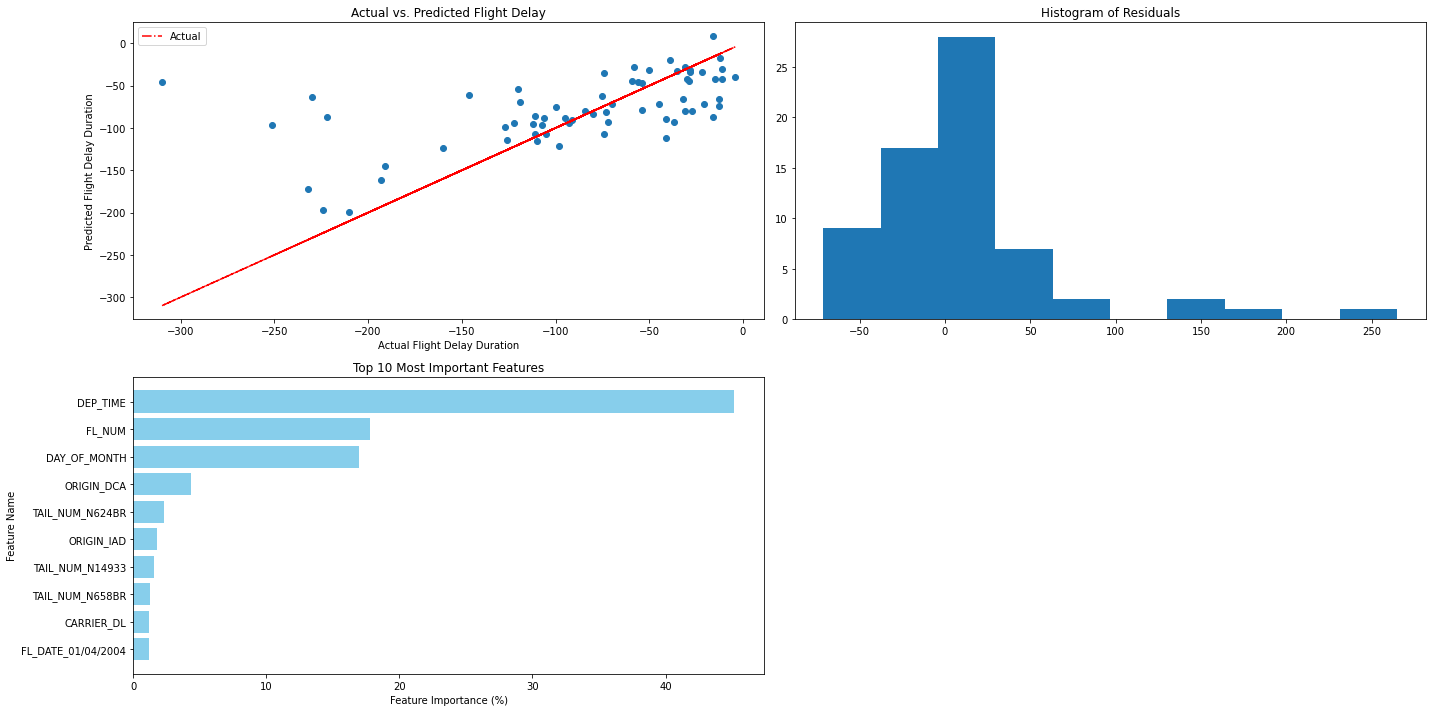

In [127]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = catboost.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Get feature importances (prettified format recommended)
feature_importances = catboost.get_feature_importance(prettified=True)

# Get top 10 features
top_10_features = feature_importances[:10]

# Extract feature names and importance values
feature_names = top_10_features["Feature Id"]
feature_importance = top_10_features["Importances"]

ax3.barh(feature_names, feature_importance, color='skyblue')
ax3.set_xlabel('Feature Importance (%)')
ax3.set_ylabel('Feature Name')
ax3.set_title('Top 10 Most Important Features')
ax3.invert_yaxis()


# Adjust layout
ax4.axis('off')
plt.tight_layout()

# Show the combined figure
plt.show()

###  15% Correlation

In [128]:
# Separate features (X) and target variable (y)
X = encoded_data_OH[highly_correlated_columns_OH_15]
y = encoded_data_OH["DEP_DIFF"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CatBoost Regressor model
catboost = CatBoostRegressor(random_state=42)  # Adjust hyperparameters as needed

# Train the model
catboost.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Feature importances
feature_importances = catboost.get_feature_importance(prettified=True)
print("Feature Importances:\n", feature_importances)

Learning rate set to 0.033174
0:	learn: 72.0174899	total: 905us	remaining: 905ms
1:	learn: 71.7018002	total: 1.6ms	remaining: 800ms
2:	learn: 71.3920763	total: 2.27ms	remaining: 753ms
3:	learn: 71.0417951	total: 2.94ms	remaining: 732ms
4:	learn: 70.7157871	total: 3.59ms	remaining: 714ms
5:	learn: 70.4511472	total: 4.23ms	remaining: 701ms
6:	learn: 70.2578683	total: 4.84ms	remaining: 687ms
7:	learn: 70.0225080	total: 5.46ms	remaining: 677ms
8:	learn: 69.7420789	total: 6.09ms	remaining: 671ms
9:	learn: 69.5496648	total: 6.72ms	remaining: 665ms
10:	learn: 69.2534725	total: 7.34ms	remaining: 660ms
11:	learn: 69.0079206	total: 7.94ms	remaining: 654ms
12:	learn: 68.9628763	total: 8.12ms	remaining: 617ms
13:	learn: 68.7230752	total: 8.74ms	remaining: 615ms
14:	learn: 68.5154358	total: 9.34ms	remaining: 613ms
15:	learn: 68.3415064	total: 9.96ms	remaining: 613ms
16:	learn: 68.1544700	total: 10.6ms	remaining: 612ms
17:	learn: 67.9264594	total: 11.3ms	remaining: 615ms
18:	learn: 67.7333202	total:

215:	learn: 50.1880996	total: 121ms	remaining: 438ms
216:	learn: 50.1683000	total: 121ms	remaining: 438ms
217:	learn: 50.1468398	total: 122ms	remaining: 438ms
218:	learn: 50.0415783	total: 123ms	remaining: 438ms
219:	learn: 49.9625799	total: 123ms	remaining: 437ms
220:	learn: 49.7861949	total: 124ms	remaining: 437ms
221:	learn: 49.7619555	total: 125ms	remaining: 437ms
222:	learn: 49.7206012	total: 125ms	remaining: 437ms
223:	learn: 49.7019621	total: 126ms	remaining: 436ms
224:	learn: 49.6780180	total: 127ms	remaining: 436ms
225:	learn: 49.6460586	total: 127ms	remaining: 436ms
226:	learn: 49.6216497	total: 128ms	remaining: 436ms
227:	learn: 49.6040057	total: 129ms	remaining: 436ms
228:	learn: 49.5764773	total: 129ms	remaining: 435ms
229:	learn: 49.4639661	total: 130ms	remaining: 435ms
230:	learn: 49.4376795	total: 131ms	remaining: 435ms
231:	learn: 49.3892284	total: 131ms	remaining: 434ms
232:	learn: 49.1936156	total: 132ms	remaining: 434ms
233:	learn: 49.1641248	total: 132ms	remaining:

424:	learn: 36.9296157	total: 254ms	remaining: 344ms
425:	learn: 36.9239216	total: 255ms	remaining: 343ms
426:	learn: 36.8713979	total: 255ms	remaining: 343ms
427:	learn: 36.8123058	total: 256ms	remaining: 342ms
428:	learn: 36.7753491	total: 257ms	remaining: 342ms
429:	learn: 36.7693814	total: 258ms	remaining: 341ms
430:	learn: 36.7336258	total: 258ms	remaining: 341ms
431:	learn: 36.6755179	total: 259ms	remaining: 341ms
432:	learn: 36.6421417	total: 260ms	remaining: 340ms
433:	learn: 36.5286889	total: 260ms	remaining: 340ms
434:	learn: 36.4524684	total: 261ms	remaining: 339ms
435:	learn: 36.3947420	total: 262ms	remaining: 339ms
436:	learn: 36.3409224	total: 262ms	remaining: 338ms
437:	learn: 36.2947072	total: 263ms	remaining: 338ms
438:	learn: 36.2604947	total: 264ms	remaining: 337ms
439:	learn: 36.2429274	total: 264ms	remaining: 337ms
440:	learn: 36.1639958	total: 265ms	remaining: 336ms
441:	learn: 36.1487839	total: 266ms	remaining: 336ms
442:	learn: 36.0721079	total: 267ms	remaining:

637:	learn: 29.0177446	total: 387ms	remaining: 220ms
638:	learn: 29.0066734	total: 388ms	remaining: 219ms
639:	learn: 28.9825149	total: 389ms	remaining: 219ms
640:	learn: 28.9384502	total: 389ms	remaining: 218ms
641:	learn: 28.9146672	total: 390ms	remaining: 217ms
642:	learn: 28.8469923	total: 391ms	remaining: 217ms
643:	learn: 28.8192325	total: 391ms	remaining: 216ms
644:	learn: 28.7837872	total: 392ms	remaining: 216ms
645:	learn: 28.7594987	total: 393ms	remaining: 215ms
646:	learn: 28.7107591	total: 393ms	remaining: 215ms
647:	learn: 28.6966949	total: 394ms	remaining: 214ms
648:	learn: 28.6660517	total: 395ms	remaining: 214ms
649:	learn: 28.6207271	total: 396ms	remaining: 213ms
650:	learn: 28.5877015	total: 396ms	remaining: 212ms
651:	learn: 28.5708220	total: 397ms	remaining: 212ms
652:	learn: 28.5462019	total: 398ms	remaining: 211ms
653:	learn: 28.5353041	total: 398ms	remaining: 211ms
654:	learn: 28.5220341	total: 399ms	remaining: 210ms
655:	learn: 28.5197037	total: 400ms	remaining:

848:	learn: 23.9816311	total: 522ms	remaining: 92.8ms
849:	learn: 23.9477631	total: 522ms	remaining: 92.2ms
850:	learn: 23.9464423	total: 523ms	remaining: 91.5ms
851:	learn: 23.9289940	total: 523ms	remaining: 90.9ms
852:	learn: 23.9090371	total: 524ms	remaining: 90.3ms
853:	learn: 23.8856576	total: 525ms	remaining: 89.7ms
854:	learn: 23.8843529	total: 525ms	remaining: 89.1ms
855:	learn: 23.8412974	total: 526ms	remaining: 88.5ms
856:	learn: 23.8344401	total: 527ms	remaining: 87.9ms
857:	learn: 23.8108562	total: 527ms	remaining: 87.2ms
858:	learn: 23.7695819	total: 528ms	remaining: 86.6ms
859:	learn: 23.7683593	total: 528ms	remaining: 86ms
860:	learn: 23.7511957	total: 529ms	remaining: 85.4ms
861:	learn: 23.7499877	total: 530ms	remaining: 84.8ms
862:	learn: 23.7416553	total: 530ms	remaining: 84.2ms
863:	learn: 23.7365829	total: 531ms	remaining: 83.6ms
864:	learn: 23.7155089	total: 532ms	remaining: 83ms
865:	learn: 23.7143365	total: 532ms	remaining: 82.3ms
866:	learn: 23.7085173	total: 53

In [129]:
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 2929.3405619096598
Root Mean Squared Error: 54.12338276484259
R-squared: 0.3819030543731784


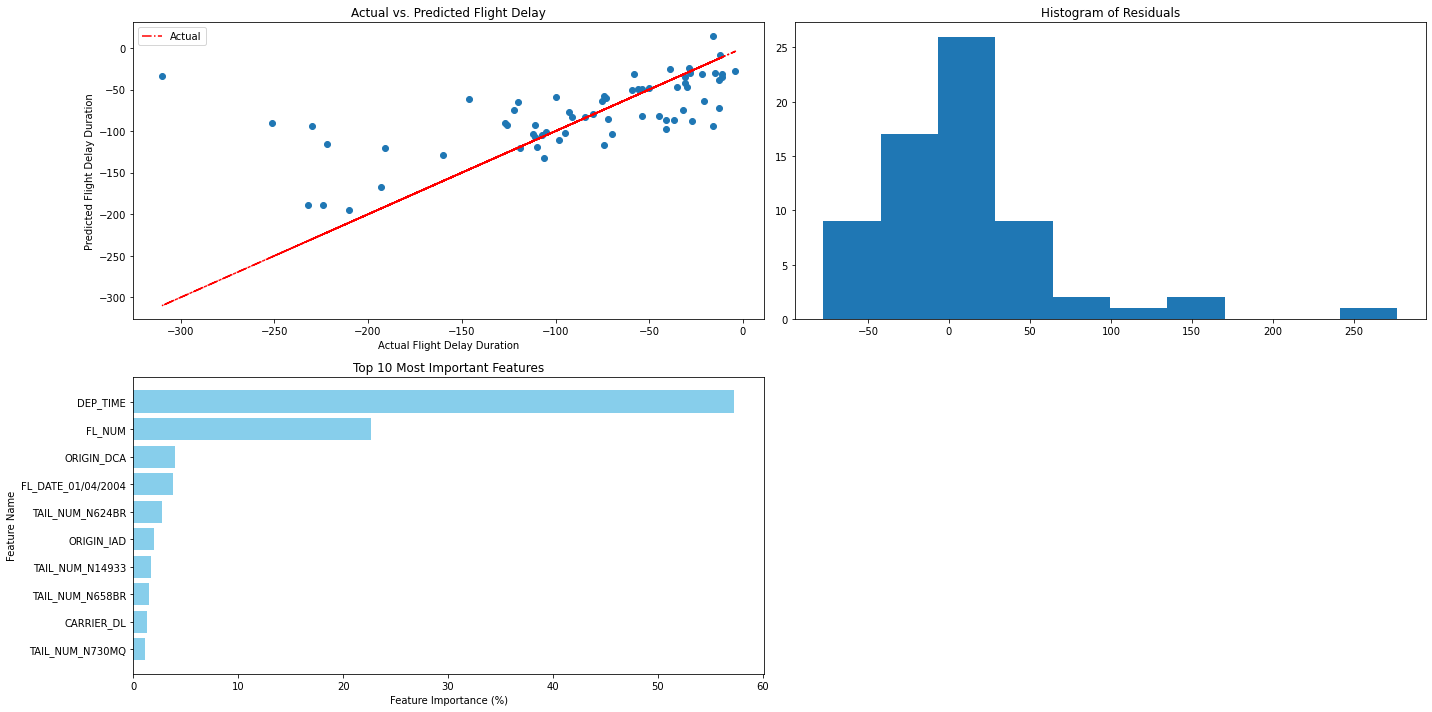

In [130]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = catboost.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Get feature importances (prettified format recommended)
feature_importances = catboost.get_feature_importance(prettified=True)

# Get top 10 features
top_10_features = feature_importances[:10]

# Extract feature names and importance values
feature_names = top_10_features["Feature Id"]
feature_importance = top_10_features["Importances"]

ax3.barh(feature_names, feature_importance, color='skyblue')
ax3.set_xlabel('Feature Importance (%)')
ax3.set_ylabel('Feature Name')
ax3.set_title('Top 10 Most Important Features')
ax3.invert_yaxis()


# Adjust layout
ax4.axis('off')
plt.tight_layout()

# Show the combined figure
plt.show()

###  20% Correlation

In [131]:
# Separate features (X) and target variable (y)
X = encoded_data_OH[highly_correlated_columns_OH_20]
y = encoded_data_OH["DEP_DIFF"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CatBoost Regressor model
catboost = CatBoostRegressor(random_state=42)  # Adjust hyperparameters as needed

# Train the model
catboost.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Feature importances
feature_importances = catboost.get_feature_importance(prettified=True)
print("Feature Importances:\n", feature_importances)

Learning rate set to 0.033174
0:	learn: 71.9018145	total: 821us	remaining: 821ms
1:	learn: 71.5771116	total: 1.46ms	remaining: 727ms
2:	learn: 71.2547248	total: 2.08ms	remaining: 691ms
3:	learn: 70.9088788	total: 2.68ms	remaining: 668ms
4:	learn: 70.6560851	total: 3.28ms	remaining: 652ms
5:	learn: 70.5332112	total: 3.87ms	remaining: 642ms
6:	learn: 70.3749734	total: 4.35ms	remaining: 618ms
7:	learn: 70.3134326	total: 4.59ms	remaining: 569ms
8:	learn: 69.9448126	total: 5.19ms	remaining: 571ms
9:	learn: 69.6693704	total: 5.81ms	remaining: 575ms
10:	learn: 69.3805078	total: 6.42ms	remaining: 577ms
11:	learn: 69.0542539	total: 7.02ms	remaining: 578ms
12:	learn: 68.7532799	total: 7.62ms	remaining: 578ms
13:	learn: 68.5092055	total: 8.2ms	remaining: 578ms
14:	learn: 68.3358617	total: 8.79ms	remaining: 577ms
15:	learn: 68.0791391	total: 9.37ms	remaining: 576ms
16:	learn: 67.9747993	total: 9.68ms	remaining: 560ms
17:	learn: 67.8965573	total: 9.91ms	remaining: 541ms
18:	learn: 67.8122166	total:

221:	learn: 49.4063539	total: 117ms	remaining: 410ms
222:	learn: 49.3114072	total: 118ms	remaining: 409ms
223:	learn: 49.2426900	total: 118ms	remaining: 409ms
224:	learn: 49.1585034	total: 119ms	remaining: 409ms
225:	learn: 49.1266725	total: 119ms	remaining: 409ms
226:	learn: 49.1166264	total: 120ms	remaining: 408ms
227:	learn: 49.0393685	total: 120ms	remaining: 408ms
228:	learn: 48.9375473	total: 121ms	remaining: 407ms
229:	learn: 48.8561332	total: 122ms	remaining: 407ms
230:	learn: 48.7579623	total: 122ms	remaining: 407ms
231:	learn: 48.7460063	total: 123ms	remaining: 406ms
232:	learn: 48.6765243	total: 123ms	remaining: 406ms
233:	learn: 48.6548460	total: 124ms	remaining: 405ms
234:	learn: 48.5418279	total: 124ms	remaining: 405ms
235:	learn: 48.4312228	total: 125ms	remaining: 405ms
236:	learn: 48.3583901	total: 126ms	remaining: 404ms
237:	learn: 48.2199678	total: 126ms	remaining: 404ms
238:	learn: 48.1891004	total: 127ms	remaining: 404ms
239:	learn: 48.0472161	total: 127ms	remaining:

439:	learn: 35.5917815	total: 249ms	remaining: 317ms
440:	learn: 35.5434473	total: 249ms	remaining: 316ms
441:	learn: 35.5314571	total: 250ms	remaining: 316ms
442:	learn: 35.5152953	total: 251ms	remaining: 315ms
443:	learn: 35.4848623	total: 251ms	remaining: 315ms
444:	learn: 35.3832543	total: 252ms	remaining: 314ms
445:	learn: 35.3538004	total: 253ms	remaining: 314ms
446:	learn: 35.2863041	total: 254ms	remaining: 314ms
447:	learn: 35.2796269	total: 254ms	remaining: 313ms
448:	learn: 35.2368348	total: 255ms	remaining: 313ms
449:	learn: 35.1738144	total: 256ms	remaining: 313ms
450:	learn: 35.1690734	total: 256ms	remaining: 312ms
451:	learn: 35.1354648	total: 257ms	remaining: 312ms
452:	learn: 35.0668681	total: 258ms	remaining: 311ms
453:	learn: 35.0100116	total: 258ms	remaining: 311ms
454:	learn: 35.0074443	total: 259ms	remaining: 310ms
455:	learn: 34.9705338	total: 260ms	remaining: 310ms
456:	learn: 34.9373920	total: 260ms	remaining: 309ms
457:	learn: 34.8984525	total: 261ms	remaining:

658:	learn: 28.1188457	total: 381ms	remaining: 197ms
659:	learn: 28.0514577	total: 382ms	remaining: 197ms
660:	learn: 28.0475078	total: 383ms	remaining: 196ms
661:	learn: 28.0023320	total: 383ms	remaining: 196ms
662:	learn: 27.9793951	total: 384ms	remaining: 195ms
663:	learn: 27.9754782	total: 385ms	remaining: 195ms
664:	learn: 27.9588452	total: 386ms	remaining: 194ms
665:	learn: 27.9389334	total: 386ms	remaining: 194ms
666:	learn: 27.8802410	total: 387ms	remaining: 193ms
667:	learn: 27.8346721	total: 388ms	remaining: 193ms
668:	learn: 27.8065533	total: 388ms	remaining: 192ms
669:	learn: 27.7917789	total: 389ms	remaining: 192ms
670:	learn: 27.7690240	total: 390ms	remaining: 191ms
671:	learn: 27.7036331	total: 390ms	remaining: 191ms
672:	learn: 27.6796311	total: 391ms	remaining: 190ms
673:	learn: 27.6772729	total: 392ms	remaining: 189ms
674:	learn: 27.6753170	total: 392ms	remaining: 189ms
675:	learn: 27.6540970	total: 393ms	remaining: 188ms
676:	learn: 27.6165887	total: 393ms	remaining:

875:	learn: 22.6822748	total: 514ms	remaining: 72.7ms
876:	learn: 22.6620097	total: 514ms	remaining: 72.1ms
877:	learn: 22.6342936	total: 515ms	remaining: 71.5ms
878:	learn: 22.5914134	total: 516ms	remaining: 71ms
879:	learn: 22.5790772	total: 516ms	remaining: 70.4ms
880:	learn: 22.5402652	total: 517ms	remaining: 69.8ms
881:	learn: 22.5083975	total: 517ms	remaining: 69.2ms
882:	learn: 22.4932770	total: 518ms	remaining: 68.6ms
883:	learn: 22.4702233	total: 519ms	remaining: 68.1ms
884:	learn: 22.4349573	total: 519ms	remaining: 67.5ms
885:	learn: 22.4220380	total: 520ms	remaining: 66.9ms
886:	learn: 22.4045522	total: 521ms	remaining: 66.3ms
887:	learn: 22.3896203	total: 521ms	remaining: 65.7ms
888:	learn: 22.3789218	total: 522ms	remaining: 65.1ms
889:	learn: 22.3443483	total: 522ms	remaining: 64.6ms
890:	learn: 22.3206139	total: 523ms	remaining: 64ms
891:	learn: 22.2999227	total: 524ms	remaining: 63.4ms
892:	learn: 22.2747059	total: 524ms	remaining: 62.8ms
893:	learn: 22.2594766	total: 52

In [132]:
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 3027.1151824443446
Root Mean Squared Error: 55.01922557110691
R-squared: 0.36127240626823


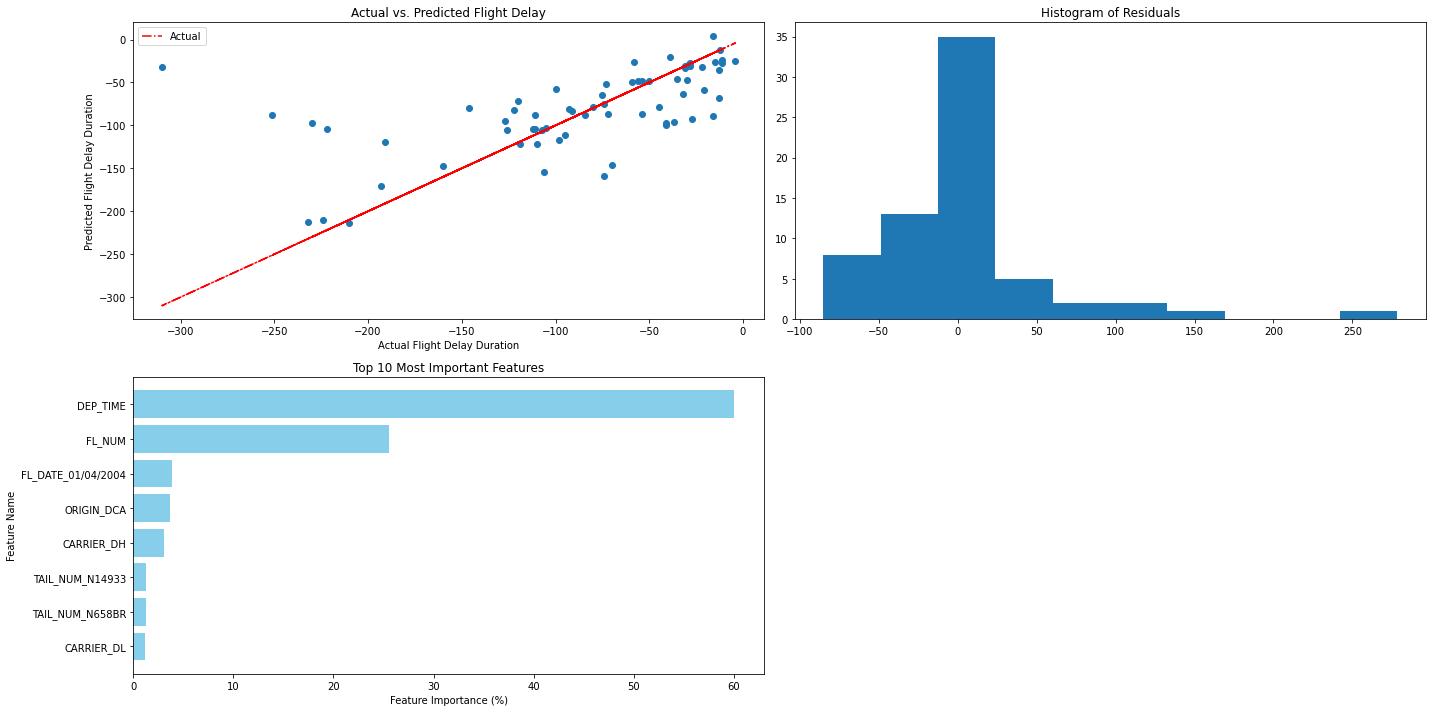

In [133]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = catboost.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Get feature importances (prettified format recommended)
feature_importances = catboost.get_feature_importance(prettified=True)

# Get top 10 features
top_10_features = feature_importances[:10]

# Extract feature names and importance values
feature_names = top_10_features["Feature Id"]
feature_importance = top_10_features["Importances"]

ax3.barh(feature_names, feature_importance, color='skyblue')
ax3.set_xlabel('Feature Importance (%)')
ax3.set_ylabel('Feature Name')
ax3.set_title('Top 10 Most Important Features')
ax3.invert_yaxis()


# Adjust layout
ax4.axis('off')
plt.tight_layout()

# Show the combined figure
plt.show()

###  25% Correlation

In [134]:
# Separate features (X) and target variable (y)
X = encoded_data_OH[highly_correlated_columns_OH_25]
y = encoded_data_OH["DEP_DIFF"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CatBoost Regressor model
catboost = CatBoostRegressor(random_state=42)  # Adjust hyperparameters as needed

# Train the model
catboost.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Feature importances
feature_importances = catboost.get_feature_importance(prettified=True)
print("Feature Importances:\n", feature_importances)

Learning rate set to 0.033174
0:	learn: 72.2400998	total: 255us	remaining: 255ms
1:	learn: 72.1902642	total: 405us	remaining: 202ms
2:	learn: 72.1412516	total: 544us	remaining: 181ms
3:	learn: 72.0930473	total: 678us	remaining: 169ms
4:	learn: 72.0456370	total: 812us	remaining: 162ms
5:	learn: 71.9990068	total: 948us	remaining: 157ms
6:	learn: 71.9531430	total: 1.08ms	remaining: 154ms
7:	learn: 71.9080322	total: 1.21ms	remaining: 150ms
8:	learn: 71.8636614	total: 1.34ms	remaining: 148ms
9:	learn: 71.8200178	total: 1.47ms	remaining: 146ms
10:	learn: 71.7770889	total: 1.61ms	remaining: 145ms
11:	learn: 71.7348624	total: 1.75ms	remaining: 144ms
12:	learn: 71.6933265	total: 1.88ms	remaining: 143ms
13:	learn: 71.6524692	total: 2.01ms	remaining: 142ms
14:	learn: 71.6122793	total: 2.14ms	remaining: 141ms
15:	learn: 71.5727453	total: 2.3ms	remaining: 141ms
16:	learn: 71.5338562	total: 2.44ms	remaining: 141ms
17:	learn: 71.4956013	total: 2.61ms	remaining: 142ms
18:	learn: 71.4579699	total: 2.74

468:	learn: 69.1923241	total: 62.8ms	remaining: 71.1ms
469:	learn: 69.1923030	total: 62.9ms	remaining: 71ms
470:	learn: 69.1922822	total: 63.1ms	remaining: 70.9ms
471:	learn: 69.1922618	total: 63.2ms	remaining: 70.7ms
472:	learn: 69.1922417	total: 63.4ms	remaining: 70.6ms
473:	learn: 69.1922220	total: 63.5ms	remaining: 70.5ms
474:	learn: 69.1922025	total: 63.7ms	remaining: 70.4ms
475:	learn: 69.1921834	total: 63.8ms	remaining: 70.3ms
476:	learn: 69.1921646	total: 64ms	remaining: 70.1ms
477:	learn: 69.1921461	total: 64.1ms	remaining: 70ms
478:	learn: 69.1921280	total: 64.3ms	remaining: 69.9ms
479:	learn: 69.1921101	total: 64.4ms	remaining: 69.8ms
480:	learn: 69.1920925	total: 64.6ms	remaining: 69.7ms
481:	learn: 69.1920752	total: 64.7ms	remaining: 69.6ms
482:	learn: 69.1920582	total: 64.9ms	remaining: 69.4ms
483:	learn: 69.1920415	total: 65ms	remaining: 69.3ms
484:	learn: 69.1920250	total: 65.2ms	remaining: 69.2ms
485:	learn: 69.1920088	total: 65.3ms	remaining: 69.1ms
486:	learn: 69.191

976:	learn: 69.1910459	total: 132ms	remaining: 3.1ms
977:	learn: 69.1910459	total: 132ms	remaining: 2.96ms
978:	learn: 69.1910459	total: 132ms	remaining: 2.83ms
979:	learn: 69.1910459	total: 132ms	remaining: 2.69ms
980:	learn: 69.1910459	total: 132ms	remaining: 2.56ms
981:	learn: 69.1910459	total: 132ms	remaining: 2.43ms
982:	learn: 69.1910459	total: 133ms	remaining: 2.29ms
983:	learn: 69.1910459	total: 133ms	remaining: 2.16ms
984:	learn: 69.1910459	total: 133ms	remaining: 2.02ms
985:	learn: 69.1910459	total: 133ms	remaining: 1.89ms
986:	learn: 69.1910459	total: 133ms	remaining: 1.75ms
987:	learn: 69.1910459	total: 133ms	remaining: 1.62ms
988:	learn: 69.1910458	total: 133ms	remaining: 1.48ms
989:	learn: 69.1910458	total: 134ms	remaining: 1.35ms
990:	learn: 69.1910458	total: 134ms	remaining: 1.21ms
991:	learn: 69.1910458	total: 134ms	remaining: 1.08ms
992:	learn: 69.1910458	total: 134ms	remaining: 944us
993:	learn: 69.1910458	total: 134ms	remaining: 809us
994:	learn: 69.1910458	total: 1

In [135]:
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 4744.227894991353
Root Mean Squared Error: 68.87835578025475
R-squared: -0.0010419441773854565


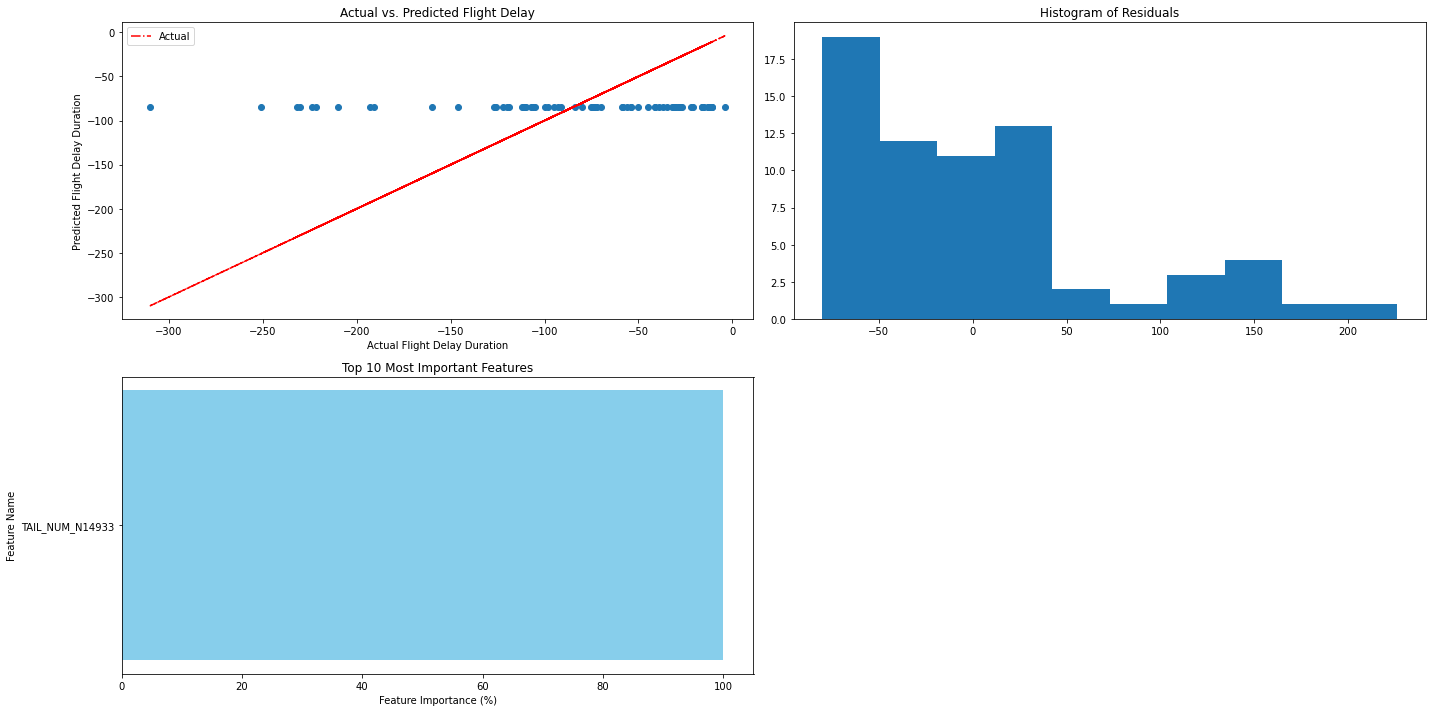

In [111]:
# Create a figure with 2 rows and 2 columns (adjust as needed)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Predictions vs. actual values scatter plot
predictions = catboost.predict(X_test)
ax1.scatter(y_test, predictions)
ax1.plot(y_test, y_test, color="red", linestyle="-.", label="Actual")
ax1.set_xlabel("Actual Flight Delay Duration")
ax1.set_ylabel("Predicted Flight Delay Duration")
ax1.set_title("Actual vs. Predicted Flight Delay")
ax1.legend()

# Residuals histogram
residuals = predictions - y_test
ax2.hist(residuals)
ax2.set_title("Histogram of Residuals")

# Get feature importances (prettified format recommended)
feature_importances = catboost.get_feature_importance(prettified=True)

# Get top 10 features
top_10_features = feature_importances[:10]

# Extract feature names and importance values
feature_names = top_10_features["Feature Id"]
feature_importance = top_10_features["Importances"]

ax3.barh(feature_names, feature_importance, color='skyblue')
ax3.set_xlabel('Feature Importance (%)')
ax3.set_ylabel('Feature Name')
ax3.set_title('Top 10 Most Important Features')
ax3.invert_yaxis()


# Adjust layout
ax4.axis('off')
plt.tight_layout()

# Show the combined figure
plt.show()

# Secondary Graphs


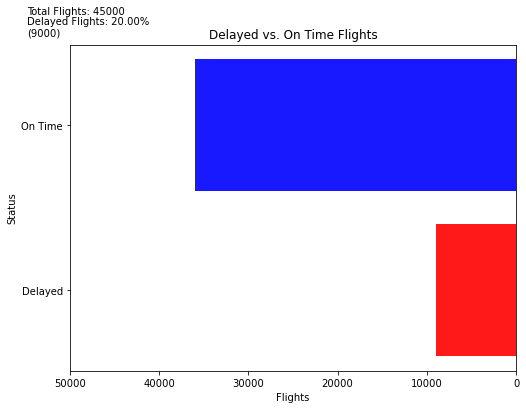

In [2]:
import matplotlib.pyplot as plt

# Create two lists, one for the bar positions and one for the bar heights
bar_pos = [1, 2]
bar_height = [9000, 36000]

# Create a bar graph with labels for the x and y axes
plt.figure(figsize=(8, 6))
plt.barh(bar_pos, bar_height, color=['red', 'blue'], alpha=0.9)
plt.xlabel("Flights")
plt.ylabel("Status")
plt.title("Delayed vs. On Time Flights")

# Add labels to each bar
plt.yticks(bar_pos, ["Delayed", "On Time"])

# Set the x-axis limits
plt.xlim(50000, 0)  # Reverse the x-axis to draw values to the right


# Add total flights and percentage delayed text to the top left corner
total_flights = sum(bar_height)
percentage_delayed = (bar_height[0] / total_flights) * 100
plt.figtext(0.05, 0.95, f"Total Flights: {total_flights}", fontsize=10, ha="left")
plt.figtext(0.05, 0.9, f"Delayed Flights: {percentage_delayed:.2f}%\n({bar_height[0]})", fontsize=10, ha="left")


# Display the bar graph
plt.show()

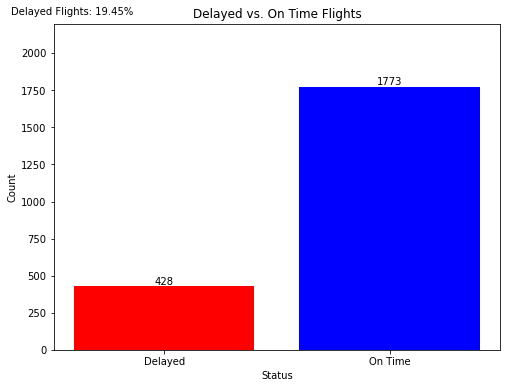

In [4]:
# Data for the bars
bar_labels = ["Delayed", "On Time"]
bar_heights = [428, 1773]
bar_colors = ["red", "blue"]

# Calculate the percentage of delayed flights
total_flights = sum(bar_heights)
percentage_delayed = (bar_heights[0] / total_flights) * 100

# Create the bar graph
fig, ax = plt.subplots(figsize=(8, 6))  # Use fig, ax for accessing patches
bars = ax.bar(bar_labels, bar_heights, color=bar_colors)

# Customize the graph
ax.set_xlabel("Status")
ax.set_ylabel("Count")
ax.set_title("Delayed vs. On Time Flights")
ax.set_ylim(0, 2200)  # Set the y-axis limits

# Add value labels above each bar (using ax.patches for compatibility)
for bar, height in zip(ax.patches, bar_heights):
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

# Add percentage delayed text to the top left corner
fig.text(0.05, 0.9, f"Delayed Flights: {percentage_delayed:.2f}%", fontsize=10, ha="left")

# Display the graph
plt.show()

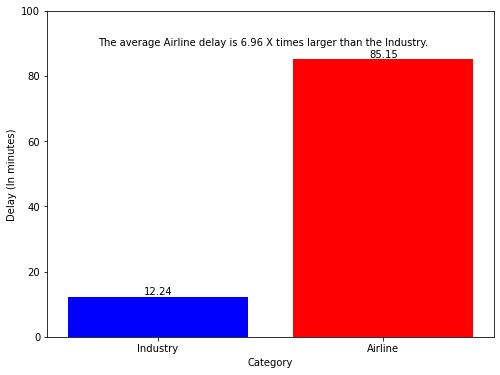

In [5]:
# Data for the bars
bar_labels = ["Industry", "Airline"]
bar_heights = [12.24, 85.15]
bar_colors = ["blue", "red"]

# Calculate the ratio of Airline to Industry
ratio = bar_heights[1] / bar_heights[0]

# Create the bar graph
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(bar_labels, bar_heights, color=bar_colors)

# Customize the graph
ax.set_xlabel("Category")
ax.set_ylabel("Delay (In minutes)")
ax.set_ylim(0, 100)  # Set the y-axis limits

# Add value labels above each bar
for bar, height in zip(ax.patches, bar_heights):
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

# Add ratio text under the title
fig.text(0.5, 0.8, f"The average Airline delay is {ratio:.2f} X times larger than the Industry.", ha="center", fontsize=10)

# Display the graph
plt.show()

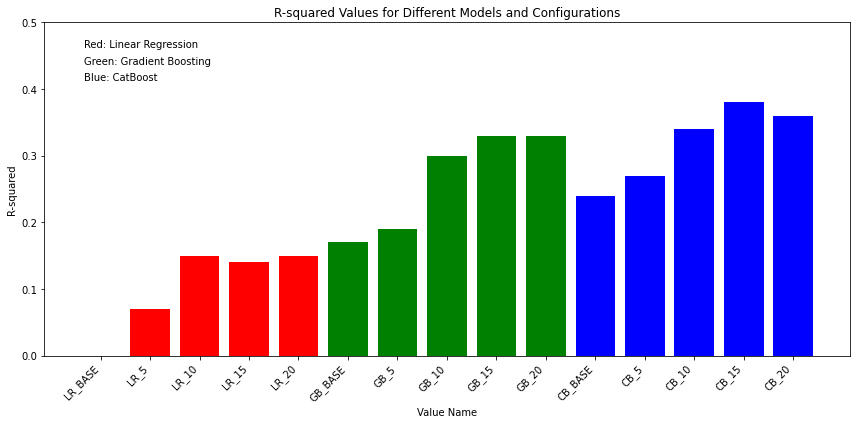

In [6]:
# R squared
r_squared_values = [0.0, 0.07, 0.15, 0.14, 0.15,  # Linear regression
                    0.17, 0.19, 0.30, 0.33, 0.33,  # Gradient boosting
                    0.24, 0.27, 0.34, 0.38, 0.36]  # CatBoost
model_types = ["Linear Regression" for _ in range(5)] + \
               ["Gradient Boosting" for _ in range(5)] + \
               ["CatBoost" for _ in range(5)]
value_names = ["LR_BASE", "LR_5", "LR_10", "LR_15", "LR_20"] + \
               ["GB_BASE", "GB_5", "GB_10", "GB_15", "GB_20"] + \
               ["CB_BASE", "CB_5", "CB_10", "CB_15", "CB_20"]

# Define colors for each model type
colors = ["red" for _ in range(5)] + ["green" for _ in range(5)] + ["blue" for _ in range(5)]

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.bar(value_names, r_squared_values, color=colors)

#Text
plt.annotate("Red: Linear Regression", xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
plt.annotate("Green: Gradient Boosting", xy=(0.05, 0.90), xycoords='axes fraction', ha='left', va='top')
plt.annotate("Blue: CatBoost", xy=(0.05, 0.85), xycoords='axes fraction', ha='left', va='top')

# Customize the plot
plt.xlabel("Value Name")
plt.ylabel("R-squared")
plt.title("R-squared Values for Different Models and Configurations")
plt.ylim(0, .5)  # Set y-axis limits to 0-1 for R-squared
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust spacing for better appearance
plt.show()

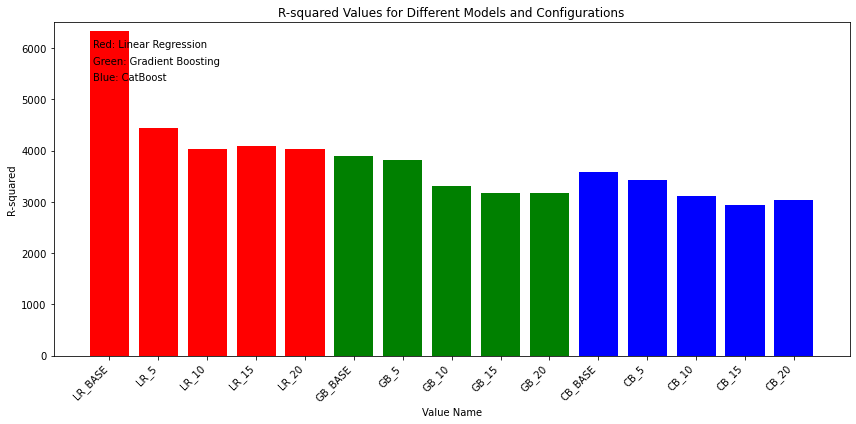

In [7]:
# Mean Squared
r_squared_values = [6325.05, 4438.03, 4033.85, 4094.69, 4039.48,  # Linear regression
                    3887.78, 3819.47, 3313.86, 3168.65, 3172.50,  # Gradient boosting
                    3582.37, 3419.63, 3123.57, 2929.34, 3027.11]  # CatBoost
model_types = ["Linear Regression" for _ in range(5)] + \
               ["Gradient Boosting" for _ in range(5)] + \
               ["CatBoost" for _ in range(5)]
value_names = ["LR_BASE", "LR_5", "LR_10", "LR_15", "LR_20"] + \
               ["GB_BASE", "GB_5", "GB_10", "GB_15", "GB_20"] + \
               ["CB_BASE", "CB_5", "CB_10", "CB_15", "CB_20"]

# Define colors for each model type
colors = ["red" for _ in range(5)] + ["green" for _ in range(5)] + ["blue" for _ in range(5)]

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.bar(value_names, r_squared_values, color=colors)

#Text
plt.annotate("Red: Linear Regression", xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
plt.annotate("Green: Gradient Boosting", xy=(0.05, 0.90), xycoords='axes fraction', ha='left', va='top')
plt.annotate("Blue: CatBoost", xy=(0.05, 0.85), xycoords='axes fraction', ha='left', va='top')

# Customize the plot
plt.xlabel("Value Name")
plt.ylabel("R-squared")
plt.title("R-squared Values for Different Models and Configurations")
plt.ylim(0, 6500)  # Set y-axis limits
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust spacing for better appearance
plt.show()

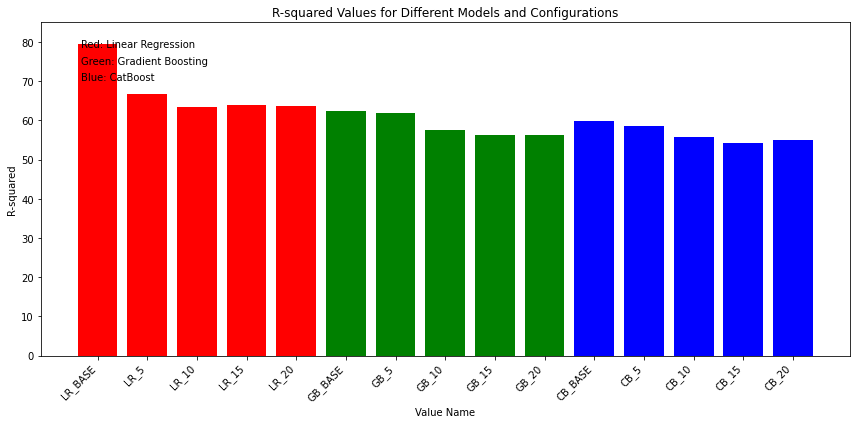

In [8]:
# Eoor Mean Squared
r_squared_values = [79.53, 66.61, 63.51, 63.98, 63.55,  # Linear regression
                    62.35, 61.80, 57.56, 56.29, 56.32,  # Gradient boosting
                    59.85, 58.47, 55.88, 54.12, 55.01]  # CatBoost
model_types = ["Linear Regression" for _ in range(5)] + \
               ["Gradient Boosting" for _ in range(5)] + \
               ["CatBoost" for _ in range(5)]
value_names = ["LR_BASE", "LR_5", "LR_10", "LR_15", "LR_20"] + \
               ["GB_BASE", "GB_5", "GB_10", "GB_15", "GB_20"] + \
               ["CB_BASE", "CB_5", "CB_10", "CB_15", "CB_20"]

# Define colors for each model type
colors = ["red" for _ in range(5)] + ["green" for _ in range(5)] + ["blue" for _ in range(5)]

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.bar(value_names, r_squared_values, color=colors)

#Text
plt.annotate("Red: Linear Regression", xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
plt.annotate("Green: Gradient Boosting", xy=(0.05, 0.90), xycoords='axes fraction', ha='left', va='top')
plt.annotate("Blue: CatBoost", xy=(0.05, 0.85), xycoords='axes fraction', ha='left', va='top')

# Customize the plot
plt.xlabel("Value Name")
plt.ylabel("R-squared")
plt.title("R-squared Values for Different Models and Configurations")
plt.ylim(0, 85)  # Set y-axis limits
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust spacing for better appearance
plt.show()